# Results in the test set

## Import needed packages

In [1]:
import SimpleITK as sitk
from os import listdir
import numpy as np
import re
import scipy
import h5py
import math
from numpy import save
from numpy import savez_compressed
from numpy import load
from volumentations import *
from random import randrange
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model
from sklearn.metrics import fbeta_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from scipy import ndimage
from patchify import patchify, unpatchify
import segmentation_models_3D as sm
import matplotlib.gridspec as gridspec
import nibabel as nb

2025-09-08 19:08:51.835307: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 19:08:51.852806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-08 19:08:51.873895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-08 19:08:51.879892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-08 19:08:51.896153: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


## Ingest data in the test set

In [2]:
# Paths to the test directory with original MRIs and segmentations
MRIs_test_dir = '/home/ch134560/data/Test/'

# Create list with all the MRI files
MRI_test_files = [MRIs_test_dir + MRI_test_file for MRI_test_file in listdir(MRIs_test_dir)]
MRI_test_files.sort()


## Iterate through the MRIs 
# Initiliaze values
current_case = re.search('case(\d+)', MRI_test_files[0])
if current_case: 
    current_case = current_case.group()
else:
    current_case = 'case missing'
current_scan = re.search('s(\d{2})', MRI_test_files[0])
if current_scan: 
    current_scan = current_scan.group()
else:
    current_scan = 'scan missing'
T1 = 0
T2 = 0
flair = 0
segmentation = 0
case_files = [None, None, None, None]
included_test_files = []

# Iterate through the MRIs 
for test_MRI in MRI_test_files:   
    # Define the case
    case = re.search('case(\d+)', test_MRI)
    if case: 
        case = case.group()
    else:
        case = 'case missing'
    scan = re.search('s(\d{2})', test_MRI)
    if scan:
        scan = scan.group()
    else:
        scan = 'scan missing'
    # Update the current case if case is new
    if case != current_case:
        current_case = case
        T1 = 0
        T2 = 0
        flair = 0
        segmentation = 0
        case_files = [None, None, None, None]
    if scan != current_scan:
        current_scan = scan
        T1 = 0
        T2 = 0
        flair = 0
        segmentation = 0     
        case_files = [None, None, None, None]
        
    # Include only cases with a T1, T2, FLAIR, and a segmentation
    if ('FLAIR' not in test_MRI) and ('lesion' not in test_MRI) and ('t2w' not in test_MRI) and T1==0:
        case_files[0] = test_MRI
        T1 += 1    
    if ('t2w' in test_MRI) and T2==0:
        case_files[1] = test_MRI
        T2 += 1    
    if ('FLAIR' in test_MRI) and flair==0:
        case_files[2] = test_MRI
        flair += 1
    if ('lesion' in test_MRI) and segmentation==0:
        case_files[3] = test_MRI
        segmentation += 1
    if T1 == 1 and T2 == 1 and flair == 1 and segmentation == 1 and len(case_files) == 4:
        included_test_files = included_test_files + [tuple(case_files)]
        T1 = 0
        T2 = 0
        flair = 0
        segmentation = 0
        case_files = [None, None, None, None]

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_556662/1046949074.py:11: SyntaxWarning: invalid escape sequence '\d'
  current_case = re.search('case(\d+)', MRI_test_files[0])
/tmp/ipykernel_556662/1046949074.py:16: SyntaxWarning: invalid escape sequence '\d'
  current_scan = re.search('s(\d{2})', MRI_test_files[0])
/tmp/ipykernel_556662/1046949074.py:31: SyntaxWarning: invalid escape sequence '\d'
  case = re.search('case(\d+)', test_MRI)
/tmp/ipykernel_556662/1046949074.py:36: SyntaxWarning: invalid escape sequence '\d'
  scan = re.search('s(\d{2})', test_MRI)


In [3]:
# Initialize the X_test and Y_test tensors
n_all_test = len(included_test_files) * 64
n_channel_test = 3
n_class_test = 2

# Initial images are 256x256x256, but they are too big for the CNN, so they are patchified into 64x64x64 patches
SX_img, SY_img, SZ_img= 256, 256, 256
SX, SY, SZ= 64, 64, 64
X_test = np.zeros( (n_all_test, SX, SY, SZ, n_channel_test), np.float32)
Y_test = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

In [4]:
# Iterate over the dataset to create the entire X_test and Y_test tensors
i = 0

for MRI_T1_file, MRI_T2_file, MRI_FLAIR_file, segmentation_file in included_test_files:

    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    MRI_T1_img = sitk.ReadImage(MRI_T1_file)
    MRI_T1_img = sitk.GetArrayFromImage(MRI_T1_img)

    # Normalize the image between 0 and 1:
    MRI_T1_img_max = np.max(MRI_T1_img)
    MRI_T1_img_min = np.min(MRI_T1_img)
    MRI_T1_img = (np.float32(MRI_T1_img) - np.float32(MRI_T1_img_min)) / (np.float32(MRI_T1_img_max) - np.float32(MRI_T1_img_min))
        
    # Resize for consistency
    MRI_T1_img = np.float32(np.transpose(MRI_T1_img, [2, 1, 0]))
    MRI_T1_img = scipy.ndimage.zoom(MRI_T1_img, zoom=(SX_img/MRI_T1_img.shape[0], SY_img/MRI_T1_img.shape[1], SZ_img/MRI_T1_img.shape[2]), order=0)

    # Patchify and introduce the MRI into the X tensor
    MRI_T1_img_patches = patchify(MRI_T1_img, (64, 64, 64), step=64)
    MRI_T1_img_patches = np.reshape(MRI_T1_img_patches, (-1, MRI_T1_img_patches.shape[3], MRI_T1_img_patches.shape[4], MRI_T1_img_patches.shape[5]))
    X_test[i:i+64, :, :, :, 0] = MRI_T1_img_patches 


    
    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    MRI_T2_img = sitk.ReadImage(MRI_T2_file)
    MRI_T2_img = sitk.GetArrayFromImage(MRI_T2_img)

    # Normalize the image between 0 and 1:
    MRI_T2_img_max = np.max(MRI_T2_img)
    MRI_T2_img_min = np.min(MRI_T2_img)
    MRI_T2_img = (np.float32(MRI_T2_img) - np.float32(MRI_T2_img_min)) / (np.float32(MRI_T2_img_max) - np.float32(MRI_T2_img_min))
        
    # Resize for consistency
    MRI_T2_img = np.float32(np.transpose(MRI_T2_img, [2, 1, 0]))
    MRI_T2_img = scipy.ndimage.zoom(MRI_T2_img, zoom=(SX_img/MRI_T2_img.shape[0], SY_img/MRI_T2_img.shape[1], SZ_img/MRI_T2_img.shape[2]), order=0)

    # Patchify and introduce the MRI into the X tensor
    MRI_T2_img_patches = patchify(MRI_T2_img, (64, 64, 64), step=64)
    MRI_T2_img_patches = np.reshape(MRI_T2_img_patches, (-1, MRI_T2_img_patches.shape[3], MRI_T2_img_patches.shape[4], MRI_T2_img_patches.shape[5]))
    X_test[i:i+64, :, :, :, 1] = MRI_T2_img_patches 

    
    
    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    MRI_FLAIR_img = sitk.ReadImage(MRI_FLAIR_file)
    MRI_FLAIR_img = sitk.GetArrayFromImage(MRI_FLAIR_img)

    # Normalize the image between 0 and 1:
    MRI_FLAIR_img_max = np.max(MRI_FLAIR_img)
    MRI_FLAIR_img_min = np.min(MRI_FLAIR_img)
    MRI_FLAIR_img = (np.float32(MRI_FLAIR_img) - np.float32(MRI_FLAIR_img_min)) / (np.float32(MRI_FLAIR_img_max) - np.float32(MRI_FLAIR_img_min))
        
    # Resize for consistency
    MRI_FLAIR_img = np.float32(np.transpose(MRI_FLAIR_img, [2, 1, 0]))
    MRI_FLAIR_img = scipy.ndimage.zoom(MRI_FLAIR_img, zoom=(SX_img/MRI_FLAIR_img.shape[0], SY_img/MRI_FLAIR_img.shape[1], SZ_img/MRI_FLAIR_img.shape[2]), order=0)

    # Patchify and introduce the MRI into the X tensor
    MRI_FLAIR_img_patches = patchify(MRI_FLAIR_img, (64, 64, 64), step=64)
    MRI_FLAIR_img_patches = np.reshape(MRI_FLAIR_img_patches, (-1, MRI_FLAIR_img_patches.shape[3], MRI_FLAIR_img_patches.shape[4], MRI_FLAIR_img_patches.shape[5]))
    X_test[i:i+64, :, :, :, 2] = MRI_FLAIR_img_patches        
        


    
    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    segmentation_img = sitk.ReadImage(segmentation_file)
    segmentation_img = sitk.GetArrayFromImage(segmentation_img)
    
    # Do not normalize because segmentations should be 1s and 0s 

    # Resize for consistency
    segmentation_img = np.transpose(segmentation_img, [2, 1, 0])
    segmentation_img = scipy.ndimage.zoom(segmentation_img, zoom=(SX_img/segmentation_img.shape[0], SY_img/segmentation_img.shape[1], SZ_img/segmentation_img.shape[2]), order=0)

    # Patchify with a homemade method and introduce the MRI into the Y tensor
    segmentation_img_patches = patchify(segmentation_img, (64, 64, 64), step=64)
    segmentation_img_patches = np.reshape(segmentation_img_patches, (-1, segmentation_img_patches.shape[3], segmentation_img_patches.shape[4], segmentation_img_patches.shape[5]))
    Y_test[i:i+64, :, :, :, 0] = segmentation_img_patches     
    
    # Update counting value
    i += 64

In [5]:
X_test.shape, Y_test.shape

((3072, 64, 64, 64, 3), (3072, 64, 64, 64, 1))

In [6]:
# Assumed that 2s and 3s are not markers of tubers
Y_test[Y_test > 1] = 0

In [7]:
# Change the number type to float 32
Y_test = Y_test.astype(np.float32)

## Define variables

In [8]:
def dice_coef(y_true, y_pred, smooth=1e-6):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

## Upload the trained model

In [9]:
# Load the trained final model for prediction
trained_u_cnn = load_model('/home/ch134560/data/TSCCNN3D_dropout_augmentation_025_075_1.h5', compile=False)

2025-09-08 19:10:24.402255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
2025-09-08 19:10:24.403596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:31:00.0, compute capability: 8.0


In [10]:
#Predict on the test data
Y_predictions = trained_u_cnn.predict(X_test, batch_size=16)
Y_test
Y_predictions.shape, Y_test.shape

I0000 00:00:1757373033.280376  556781 service.cc:146] XLA service 0x7fa314029560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757373033.280438  556781 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1757373033.280450  556781 service.cc:154]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-09-08 19:10:33.307647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-08 19:10:33.435537: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  2/192 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step

I0000 00:00:1757373044.231907  556781 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 ━━━━━━━━━━━━━━━━━━━━ 36s 128ms/step


((3072, 64, 64, 64, 1), (3072, 64, 64, 64, 1))

In [11]:
# Define the threshold probability to call a tuber
Y_predictions[Y_predictions < 0.5] = 0.0
Y_predictions[Y_predictions >= 0.5] = 1.0

In [12]:
# Test Dice Coefficient
dice_coef(Y_test, Y_predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=0.820228>

## Evaluate goodness of segmentations in MRI patches

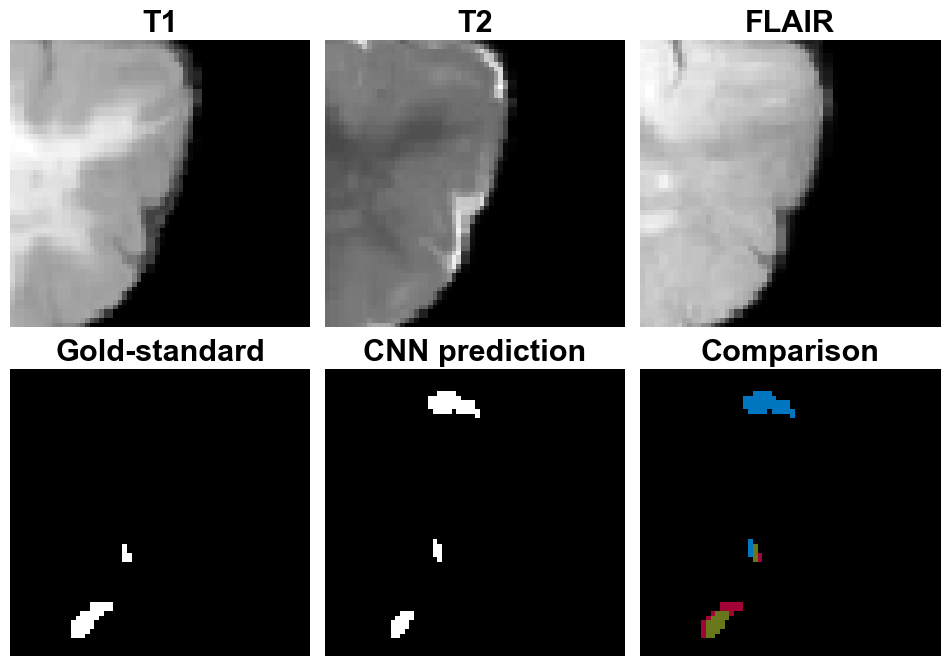

In [13]:
# Test image 1
test_T1_img = X_test[45, :, :, 41, 0]
test_T2_img = X_test[45, :, :, 41, 1]
test_FLAIR_img = X_test[45, :, :, 41, 2]
true_mask = Y_test[45, :, :, 41, 0]
predicted_mask = Y_predictions[45, :, :, 41,  0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

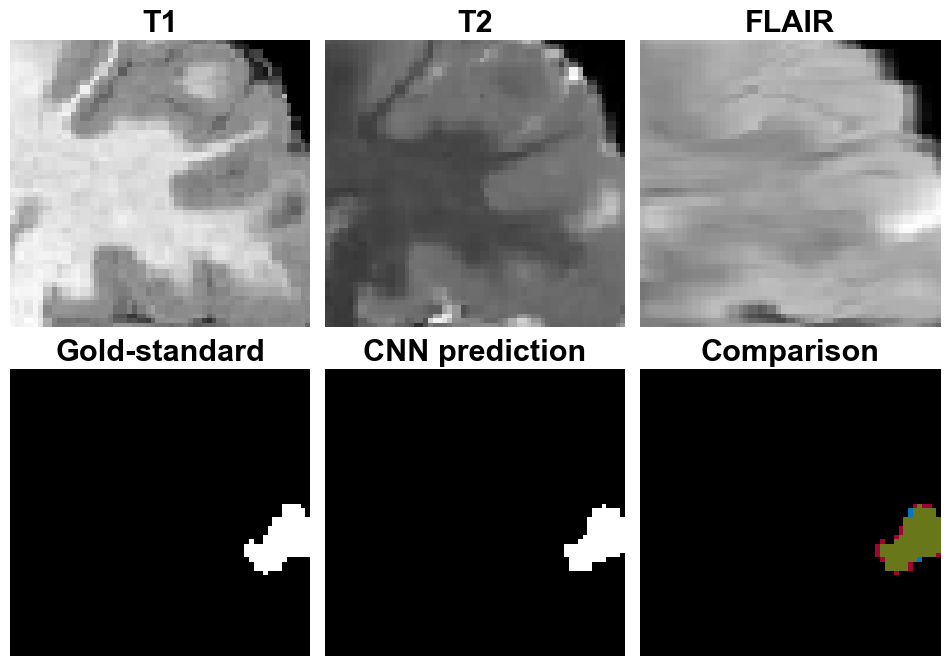

In [14]:
# Test image 2
test_T1_img = X_test[154, :, 35, :, 0]
test_T2_img = X_test[154, :, 35, :, 1]
test_FLAIR_img = X_test[154, :, 35, :, 2]
true_mask = Y_test[154, :, 35, :, 0]
predicted_mask = Y_predictions[154, :, 35, :,  0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

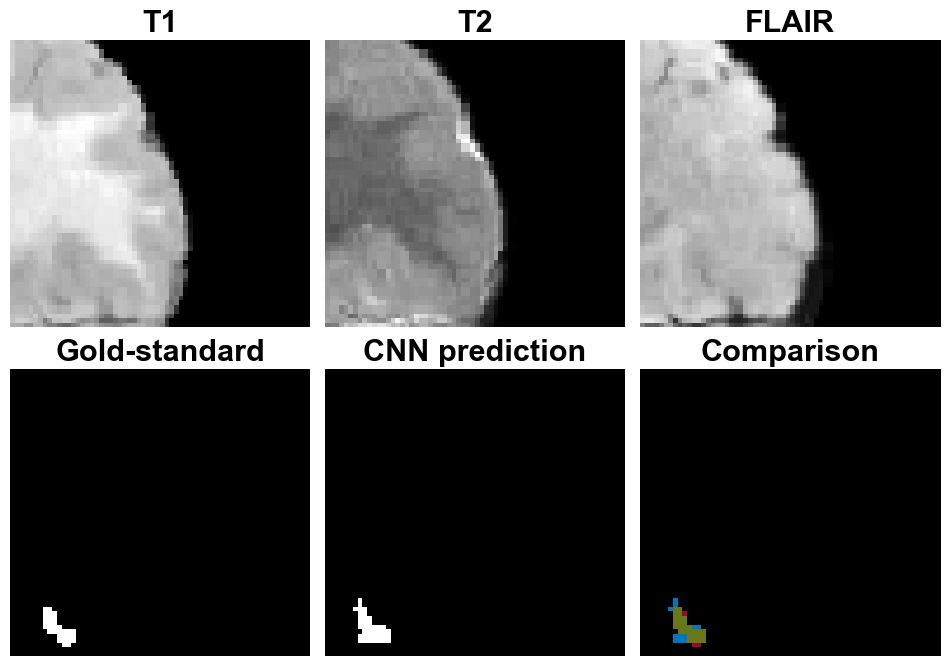

In [15]:
# Test image 3
test_T1_img = X_test[1245, :, :, 38, 0]
test_T2_img = X_test[1245, :, :, 38, 1]
test_FLAIR_img = X_test[1245, :, :, 38, 2]
true_mask = Y_test[1245, :, :, 38, 0]
predicted_mask = Y_predictions[1245, :, :, 38, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

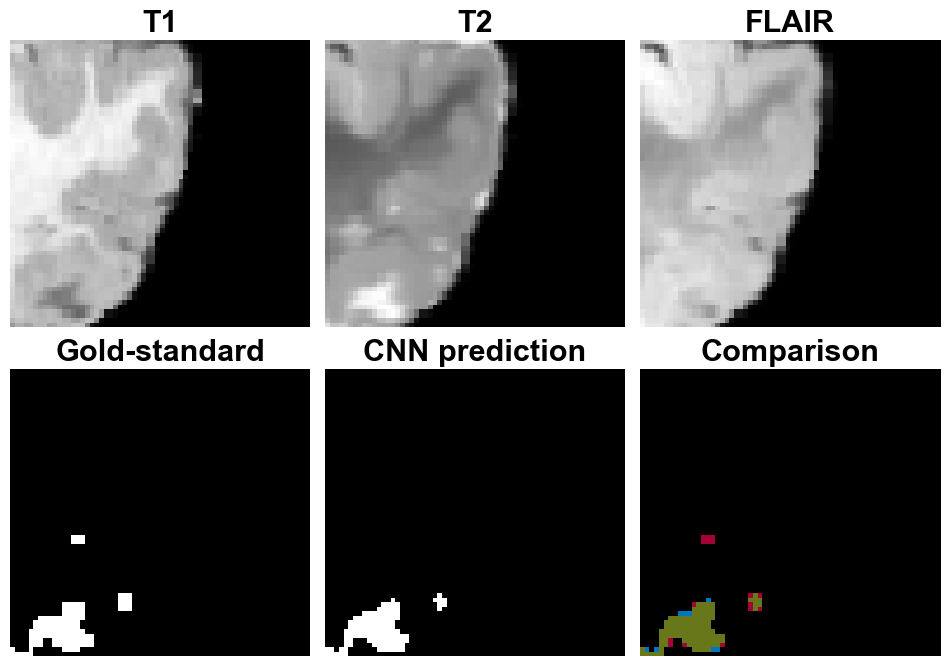

In [16]:
# Test image 4
test_T1_img = X_test[2477, :, :, 40, 0]
test_T2_img = X_test[2477, :, :, 40, 1]
test_FLAIR_img = X_test[2477, :, :, 40, 2]
true_mask = Y_test[2477, :, :, 40, 0]
predicted_mask = Y_predictions[2477, :, :, 40, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

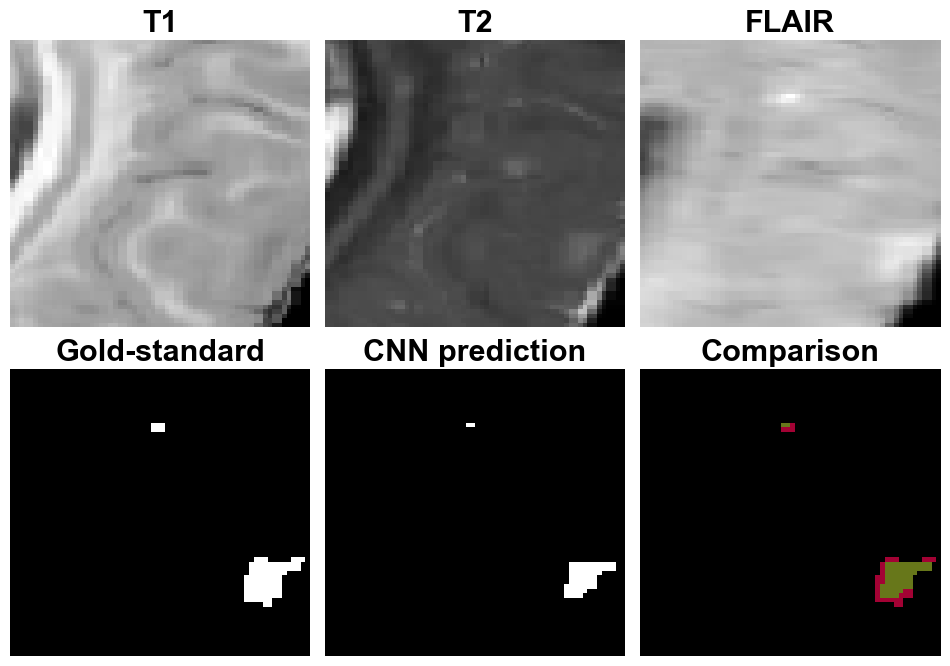

In [17]:
# Test image 5
test_T1_img = X_test[1050, 55, :, :, 0]
test_T2_img = X_test[1050, 55, :, :, 1]
test_FLAIR_img = X_test[1050, 55, :, :, 2]
true_mask = Y_test[1050, 55, :, :, 0]
predicted_mask = Y_predictions[1050, 55, :, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

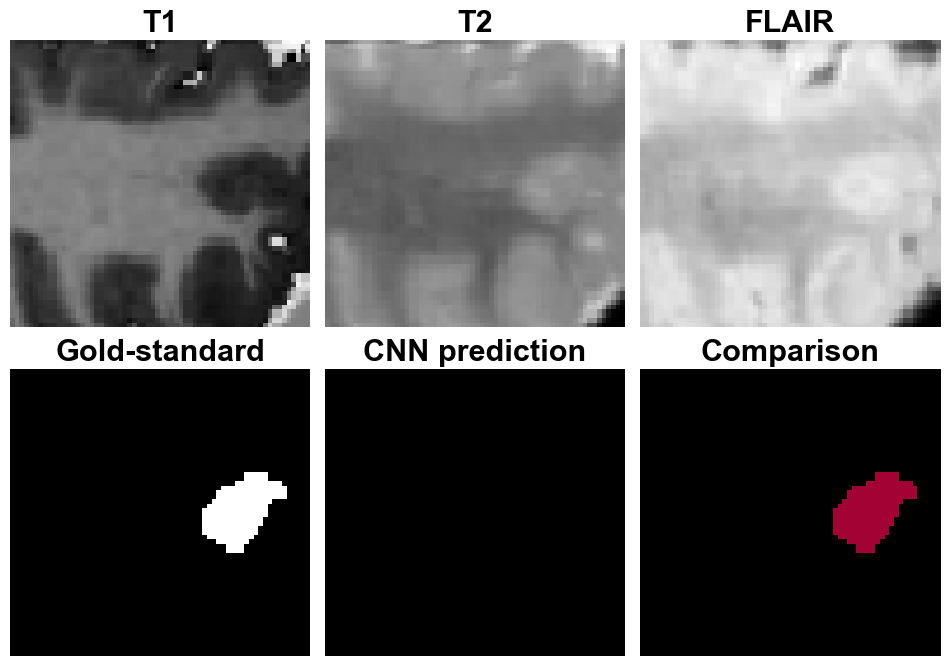

In [18]:
# Test image 6
test_T1_img = X_test[1706, :, :, 29, 0]
test_T2_img = X_test[1706, :, :, 29, 1]
test_FLAIR_img = X_test[1706, :, :, 29, 2]
true_mask = Y_test[1706, :, :, 29, 0]
predicted_mask = Y_predictions[1706, :, :, 29, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

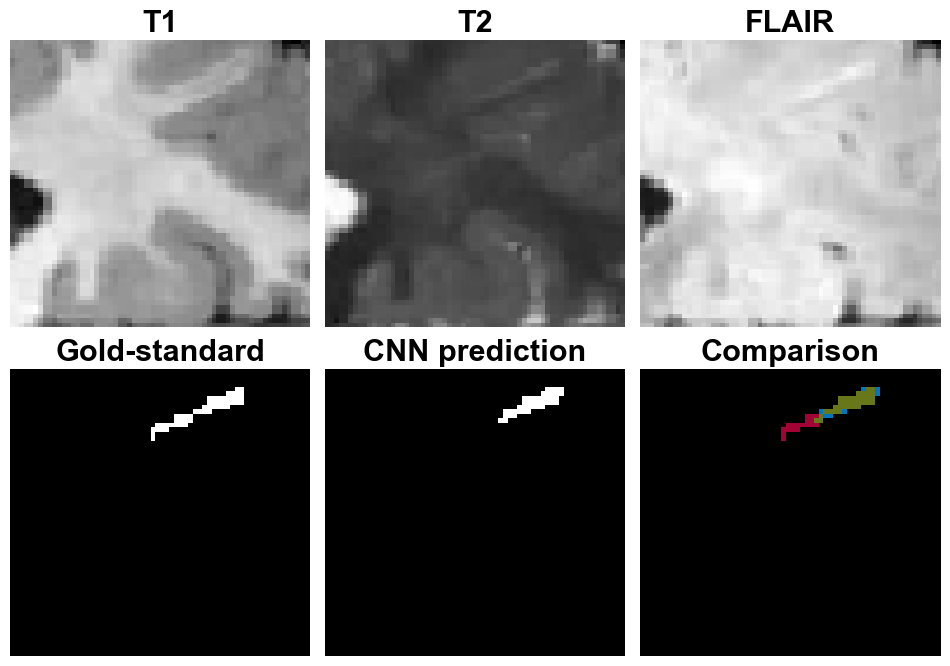

In [19]:
# Test image 7
test_T1_img = X_test[2070, :, 41, :, 0]
test_T2_img = X_test[2070, :, 41, :, 1]
test_FLAIR_img = X_test[2070, :, 41, :, 2]
true_mask = Y_test[2070, :, 41, :, 0]
predicted_mask = Y_predictions[2070, :, 41, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

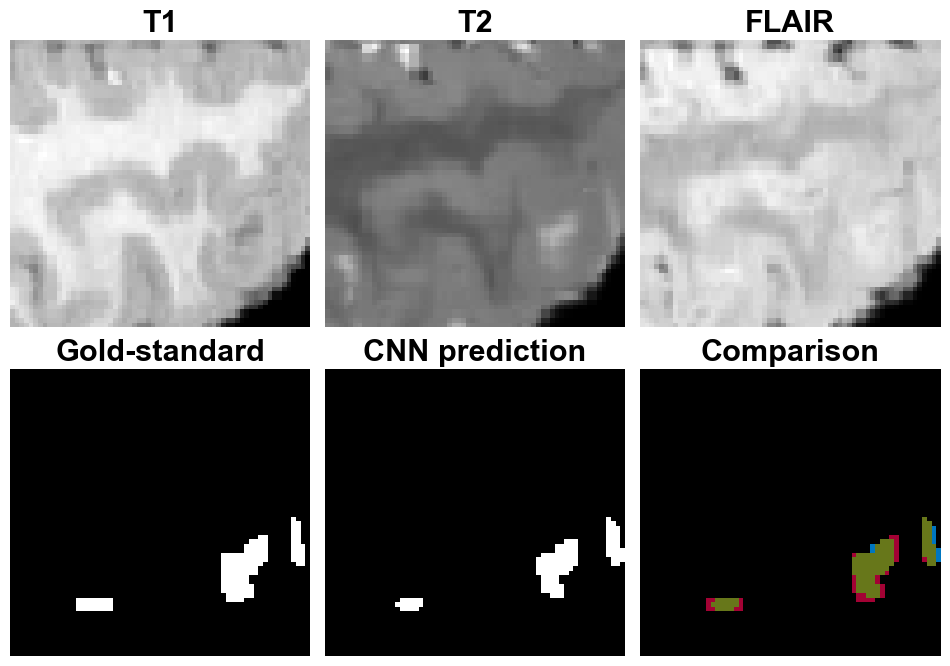

In [20]:
# Test image 8
test_T1_img = X_test[362, :, :, 38, 0]
test_T2_img = X_test[362, :, :, 38, 1]
test_FLAIR_img = X_test[362, :, :, 38, 2]
true_mask = Y_test[362, :, :, 38, 0]
predicted_mask = Y_predictions[362, :, :, 38,  0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

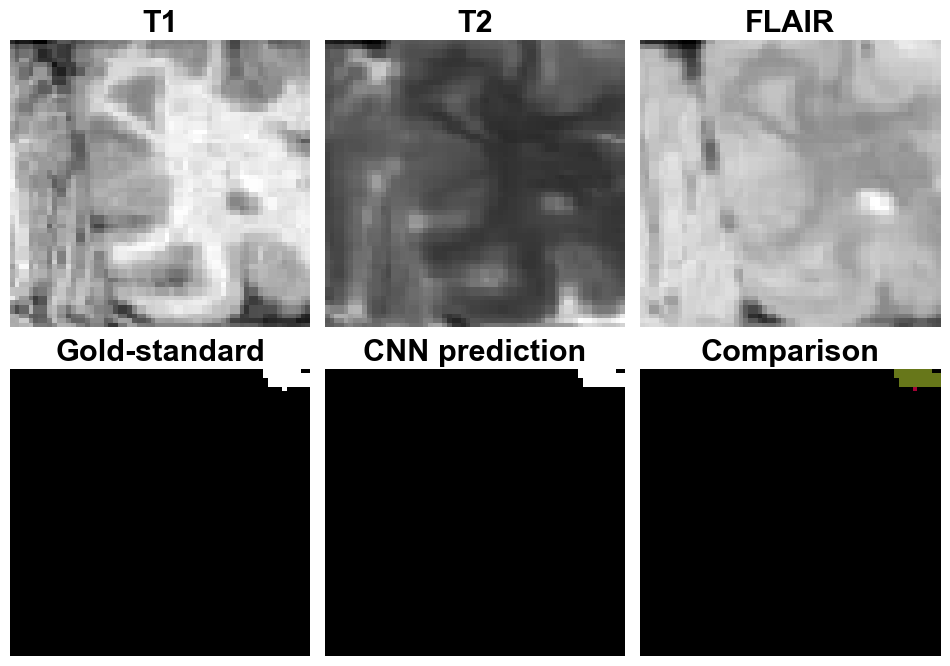

In [21]:
# Test image 9
test_T1_img = X_test[3025, :, 59, :, 0]
test_T2_img = X_test[3025, :, 59, :, 1]
test_FLAIR_img = X_test[3025, :, 59, :, 2]
true_mask = Y_test[3025, :, 59, :, 0]
predicted_mask = Y_predictions[3025, :, 59, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

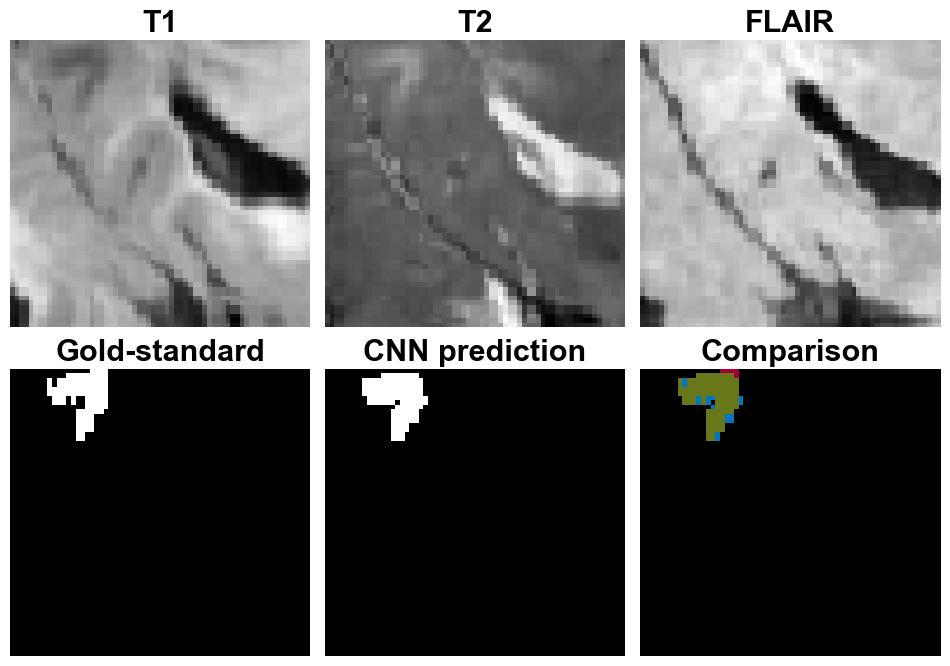

In [22]:
# Test image 10
test_T1_img = X_test[2005, :, 31, :, 0]
test_T2_img = X_test[2005, :, 31, :, 1]
test_FLAIR_img = X_test[2005, :, 33, :, 2]
true_mask = Y_test[2005, :, 31, :, 0]
predicted_mask = Y_predictions[2005, :, 31, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

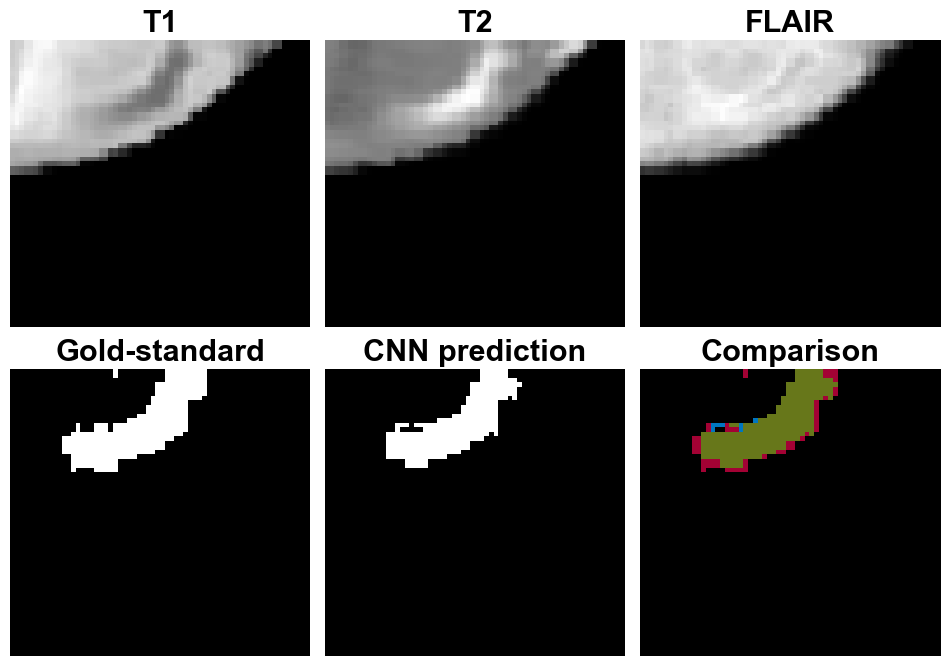

In [23]:
# Test image 11
test_T1_img = X_test[2298, :, 10, :, 0]
test_T2_img = X_test[2298, :, 10, :, 1]
test_FLAIR_img = X_test[2298, :, 10, :, 2]
true_mask = Y_test[2298, :, 10, :, 0]
predicted_mask = Y_predictions[2298, :, 10, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

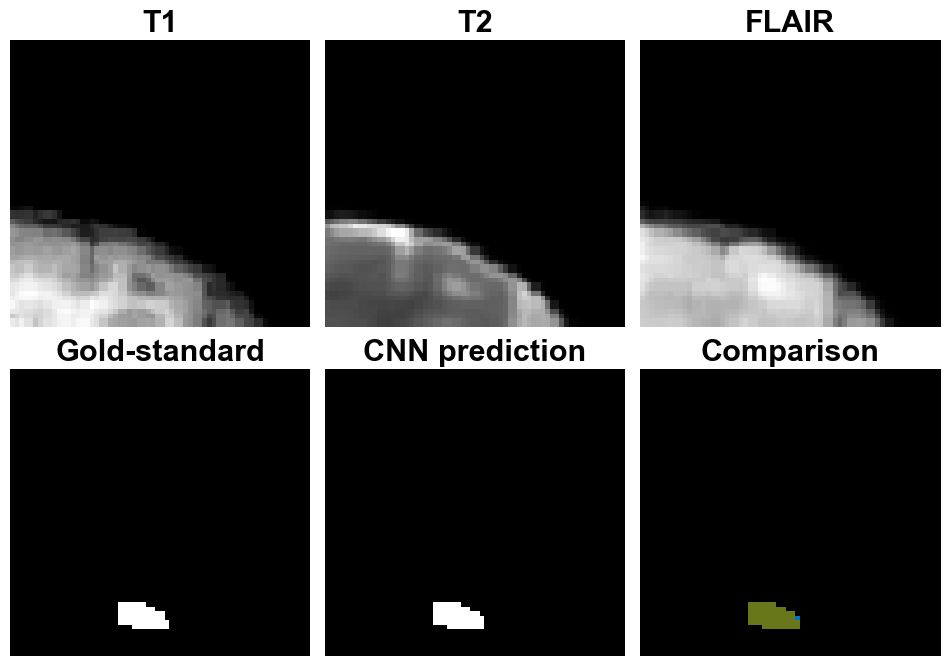

In [24]:
# Test image 12
test_T1_img = X_test[3018, :, 20, :, 0]
test_T2_img = X_test[3018, :, 20, :, 1]
test_FLAIR_img = X_test[3018, :, 20, :, 2]
true_mask = Y_test[3018, :, 20, :, 0]
predicted_mask = Y_predictions[3018, :, 20, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

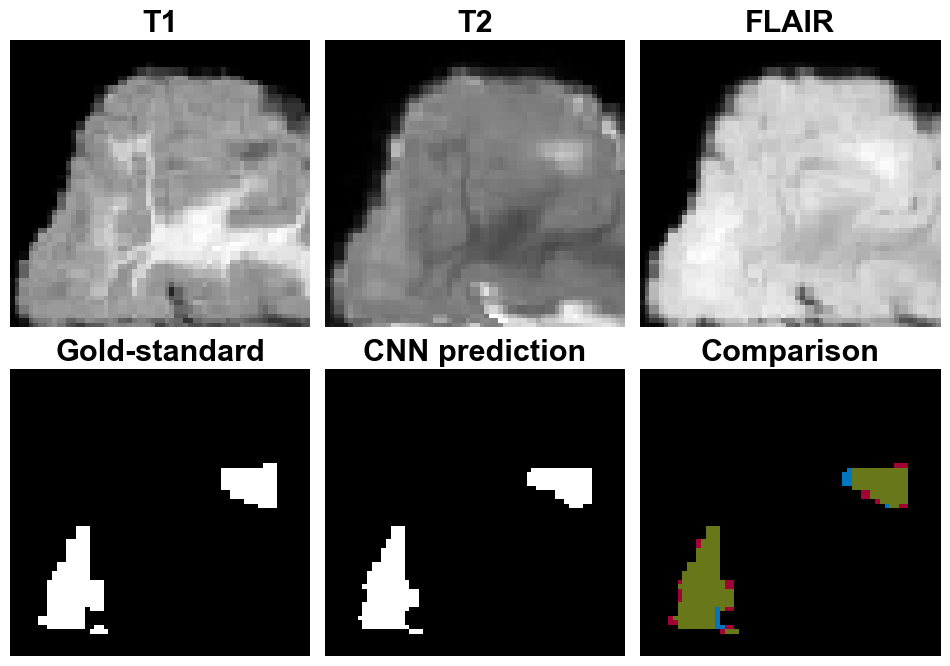

In [25]:
# Test image 13
test_T1_img = X_test[1181, :, 24, :, 0]
test_T2_img = X_test[1181, :, 24, :, 1]
test_FLAIR_img = X_test[1181, :, 24, :, 2]
true_mask = Y_test[1181, :, 24, :, 0]
predicted_mask = Y_predictions[1181, :, 24, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

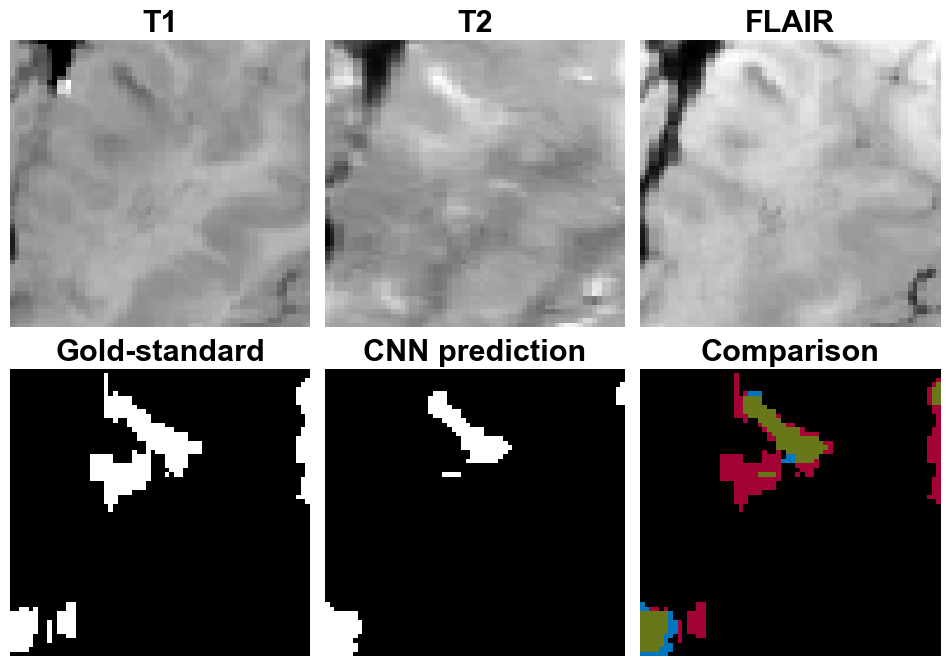

In [26]:
# Test image 14
test_T1_img = X_test[1381, 63, :, :, 0]
test_T2_img = X_test[1381, 63, :, :, 1]
test_FLAIR_img = X_test[1381, 63, :, :, 2]
true_mask = Y_test[1381, 63, :, :, 0]
predicted_mask = Y_predictions[1381, 63, :, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

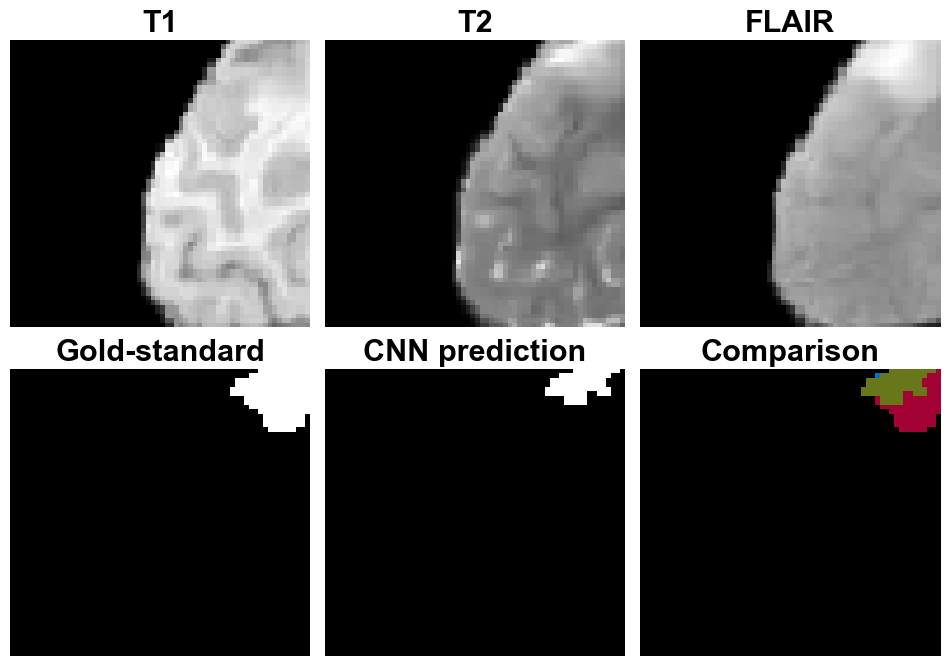

In [27]:
# Test image 15
test_T1_img = X_test[2385, :, :, 32, 0]
test_T2_img = X_test[2385, :, :, 32, 1]
test_FLAIR_img = X_test[2385, :, :, 32, 2]
true_mask = Y_test[2385, :, :, 32, 0]
predicted_mask = Y_predictions[2385, :, :, 32, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

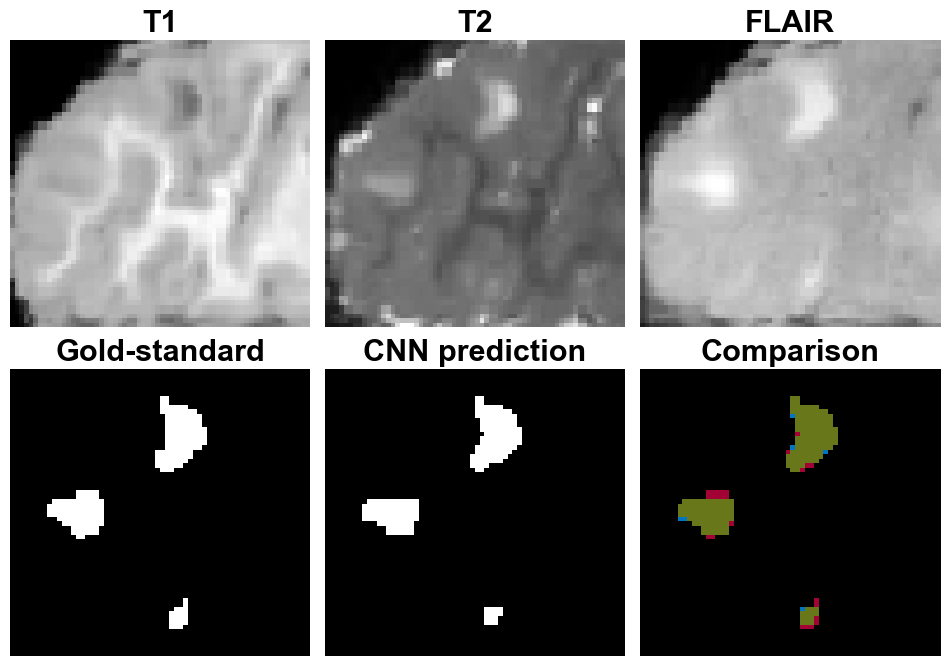

In [28]:
# Test image 16
test_T1_img = X_test[2134, :, :, 56, 0]
test_T2_img = X_test[2134, :, :, 56, 1]
test_FLAIR_img = X_test[2134, :, :, 56, 2]
true_mask = Y_test[2134, :, :, 56, 0]
predicted_mask = Y_predictions[2134, :, :, 56, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

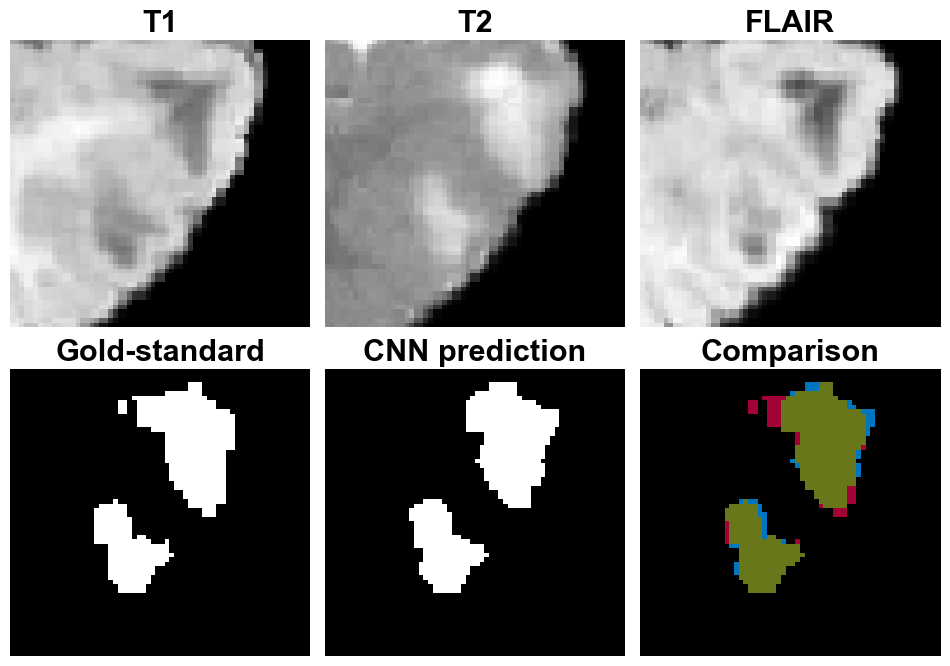

In [29]:
# Test image 17
test_T1_img = X_test[1134, :, 0, :, 0]
test_T2_img = X_test[1134, :, 0, :, 1]
test_FLAIR_img = X_test[1134, :, 0, :, 2]
true_mask = Y_test[1134, :, 0, :, 0]
predicted_mask = Y_predictions[1134, :, 0, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

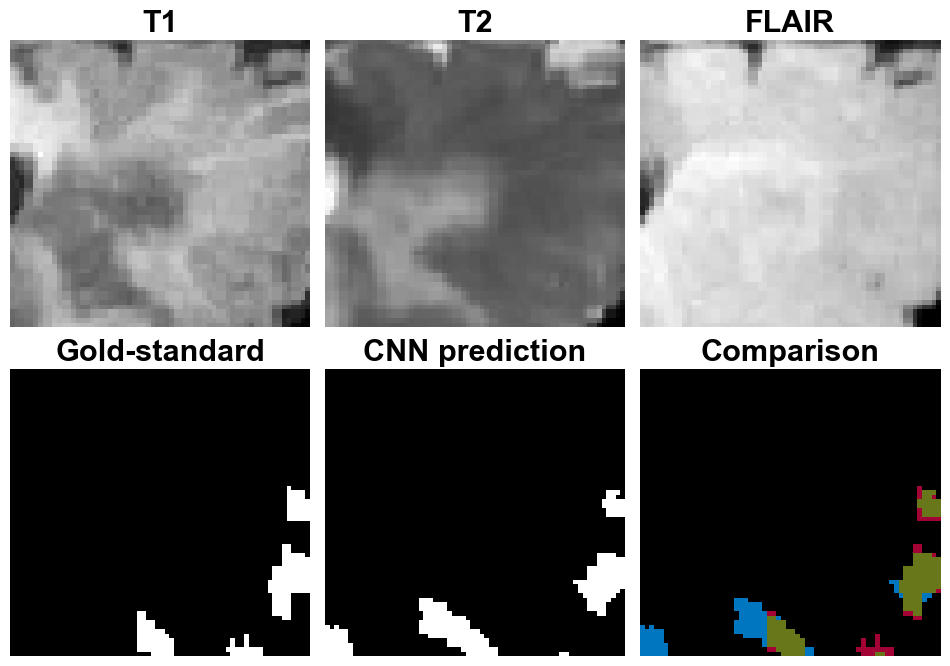

In [30]:
# Test image 18
test_T1_img = X_test[934, :, 37, :, 0]
test_T2_img = X_test[934, :, 37, :, 1]
test_FLAIR_img = X_test[934, :, 37, :, 2]
true_mask = Y_test[934, :, 37, :, 0]
predicted_mask = Y_predictions[934, :, 37, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

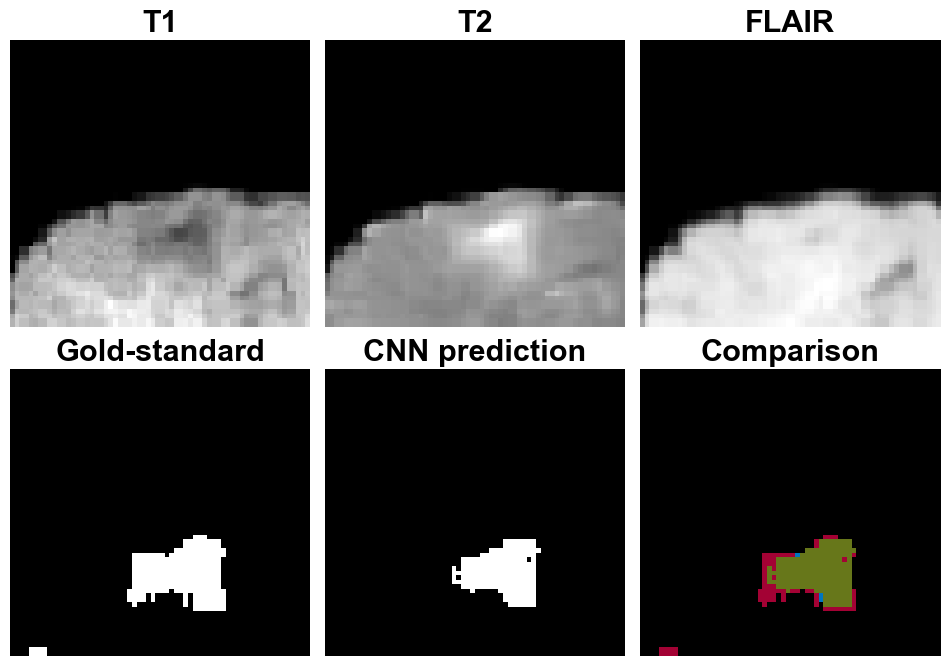

In [31]:
# Test image 19
test_T1_img = X_test[1861, :, 31, :, 0]
test_T2_img = X_test[1861, :, 31, :, 1]
test_FLAIR_img = X_test[1861, :, 31, :, 2]
true_mask = Y_test[1861, :, 31, :, 0]
predicted_mask = Y_predictions[1861, :, 31, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

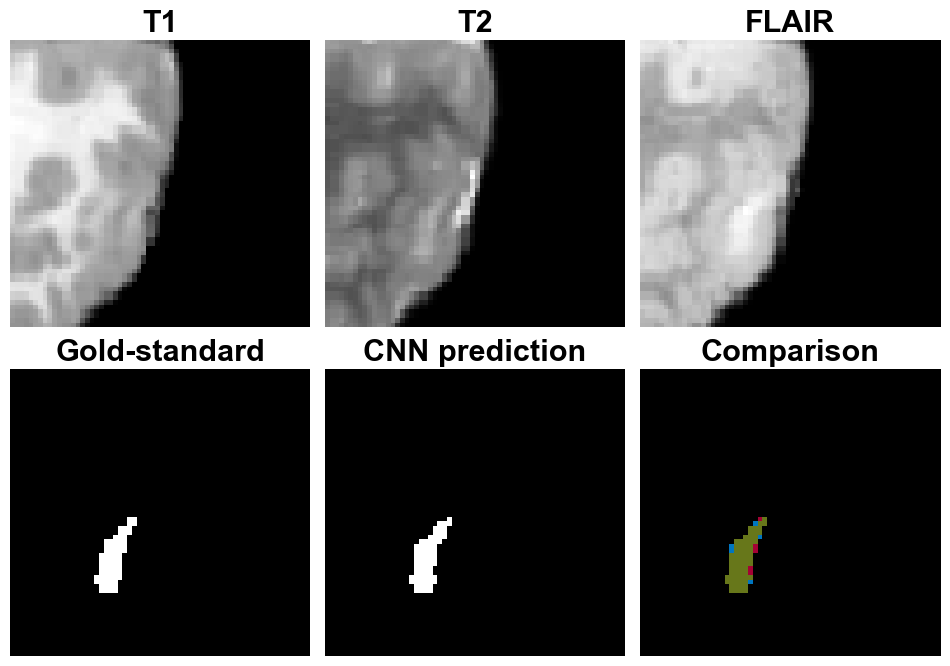

In [32]:
# Test image 20
test_T1_img = X_test[2861, :, :, 22, 0]
test_T2_img = X_test[2861, :, :, 22, 1]
test_FLAIR_img = X_test[2861, :, :, 22, 2]
true_mask = Y_test[2861, :, :, 22, 0]
predicted_mask = Y_predictions[2861, :, :, 22, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

<a id='images'></a>

## TO SEE EXAMPLES OF SEGMENTATIONS IN SMALL MRI PATCHES --> ↑↑ SCROLL UP ↑↑
## TO SEE EXAMPLES OF SEGMENTATIONS IN THE FULL MRI --> ↓↓ SCROLL DOWN ↓↓ 

## Evaluate goodness of segmentations in full MRIs

In [33]:
# Extract the different sequences
X_test_reshaped_T1 = X_test[:, :, :, :, 0]
X_test_reshaped_T2 = X_test[:, :, :, :, 1]
X_test_reshaped_FLAIR = X_test[:, :, :, :, 2]
Y_test_reshaped = Y_test[:, :, :, :, 0]
Y_predictions_reshaped = Y_predictions[:, :, :, :, 0]

In [34]:
# Modify shape of patches
i = 0 
X_test_full_images_T1 = np.zeros( (int(X_test_reshaped_T1.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
X_test_full_images_T2 = np.zeros( (int(X_test_reshaped_T2.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
X_test_full_images_FLAIR = np.zeros( (int(X_test_reshaped_FLAIR.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
Y_test_full_images = np.zeros( (int(Y_test_reshaped.shape[0]/SX), SX_img, SY_img, SZ_img), np.uint8)
Y_predictions_full_images = np.zeros( (int(Y_predictions_reshaped.shape[0]/SX), SX_img, SY_img, SZ_img), np.uint8)

# Reconstruct the full images from their patches
while i < X_test.shape[0]:
    
    X_reshaped_patches_T1 = np.reshape(X_test_reshaped_T1[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_T1 = unpatchify(X_reshaped_patches_T1, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_T1 = np.transpose(X_reconstructed_image_T1, [0, 1, 2])
    X_reconstructed_image_T1 = np.flip(X_reconstructed_image_T1, axis=(0,1))
    X_test_full_images_T1[int(i/64), :, :, :] =  X_reconstructed_image_T1

    X_reshaped_patches_T2 = np.reshape(X_test_reshaped_T2[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_T2 = unpatchify(X_reshaped_patches_T2, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_T2 = np.transpose(X_reconstructed_image_T2, [0, 1, 2])
    X_reconstructed_image_T2 = np.flip(X_reconstructed_image_T2, axis=(0,1))
    X_test_full_images_T2[int(i/64), :, :, :] =  X_reconstructed_image_T2

    X_reshaped_patches_FLAIR = np.reshape(X_test_reshaped_FLAIR[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_FLAIR = unpatchify(X_reshaped_patches_FLAIR, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_FLAIR = np.transpose(X_reconstructed_image_FLAIR, [0, 1, 2])
    X_reconstructed_image_FLAIR = np.flip(X_reconstructed_image_FLAIR, axis=(0,1))
    X_test_full_images_FLAIR[int(i/64), :, :, :] =  X_reconstructed_image_FLAIR
    
    Y_test_reshaped_patches = np.reshape(Y_test_reshaped[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    Y_test_reconstructed_image = unpatchify(Y_test_reshaped_patches, (SX_img, SY_img, SZ_img))
    Y_test_reconstructed_image = np.transpose(Y_test_reconstructed_image, [0, 1, 2])
    Y_test_reconstructed_image = np.flip(Y_test_reconstructed_image, axis=(0,1))
    Y_test_full_images[int(i/64), :, :, :] =  Y_test_reconstructed_image 
 
    Y_predictions_reshaped_patches = np.reshape(Y_predictions_reshaped[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    Y_predictions_reconstructed_image = unpatchify(Y_predictions_reshaped_patches, (SX_img, SY_img, SZ_img))
    Y_predictions_reconstructed_image = np.transpose(Y_predictions_reconstructed_image, [0, 1, 2])
    Y_predictions_reconstructed_image = np.flip(Y_predictions_reconstructed_image, axis=(0,1))
    Y_predictions_full_images[int(i/64), :, :, :] =  Y_predictions_reconstructed_image 
    
    i += SX

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


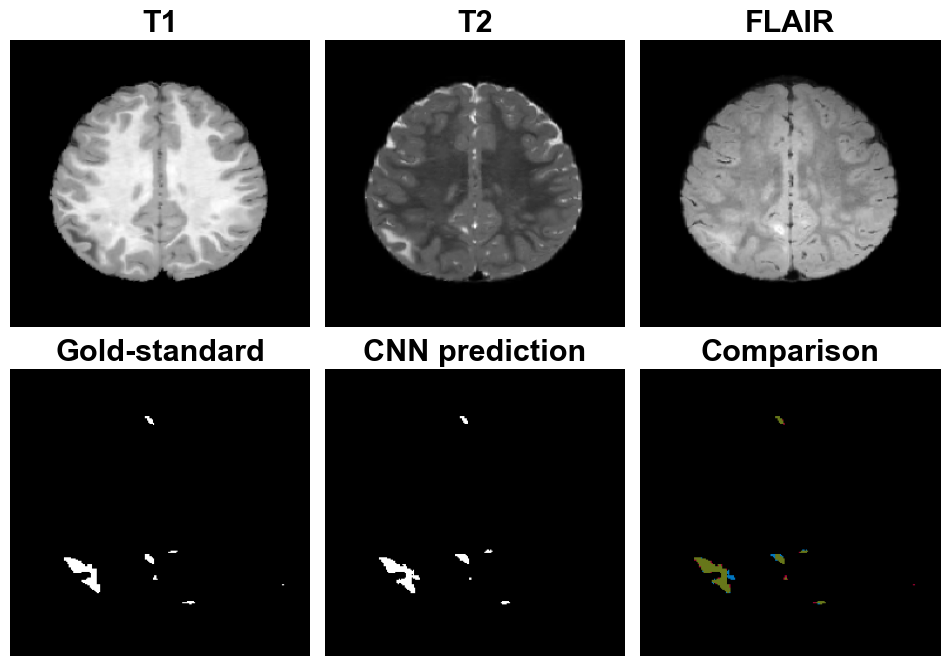

In [35]:
# Test 1 figure of 2D slice
test_T1_img = X_test_full_images_T1[1, :, :, 150]
test_T2_img = X_test_full_images_T2[1, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[1, :, :, 150]
true_mask = Y_test_full_images[1, :, :, 150]
predicted_mask = Y_predictions_full_images[1, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


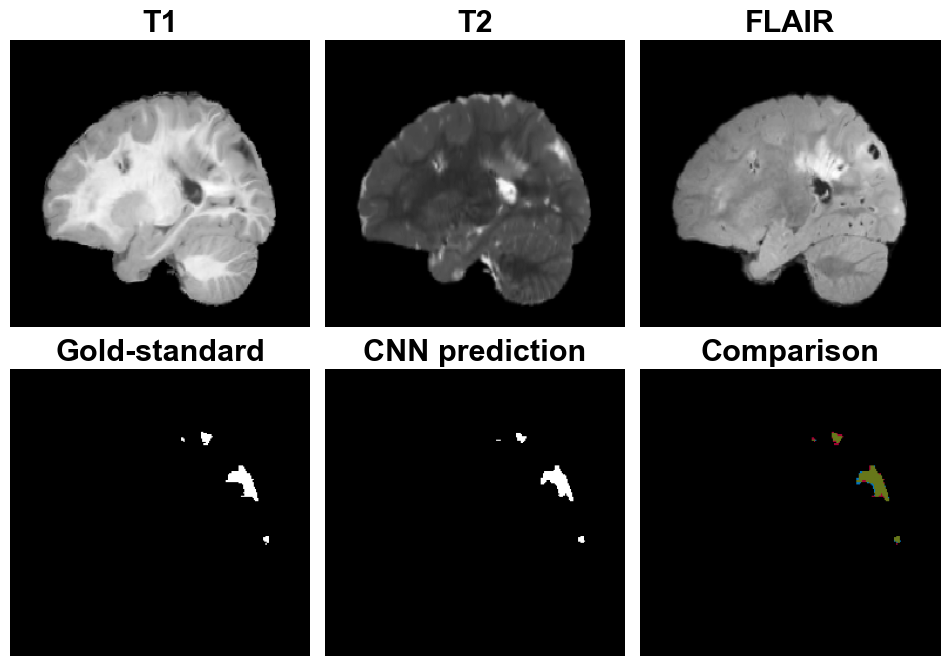

In [36]:
# Test 2 figure of 2D slice
test_T1_img = X_test_full_images_T1[0, 160, :, :]
test_T2_img = X_test_full_images_T2[0, 160, :, :]
test_FLAIR_img = X_test_full_images_FLAIR[0, 160, :, :]
true_mask = Y_test_full_images[0, 160, :, :]
predicted_mask = Y_predictions_full_images[0, 160, :, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


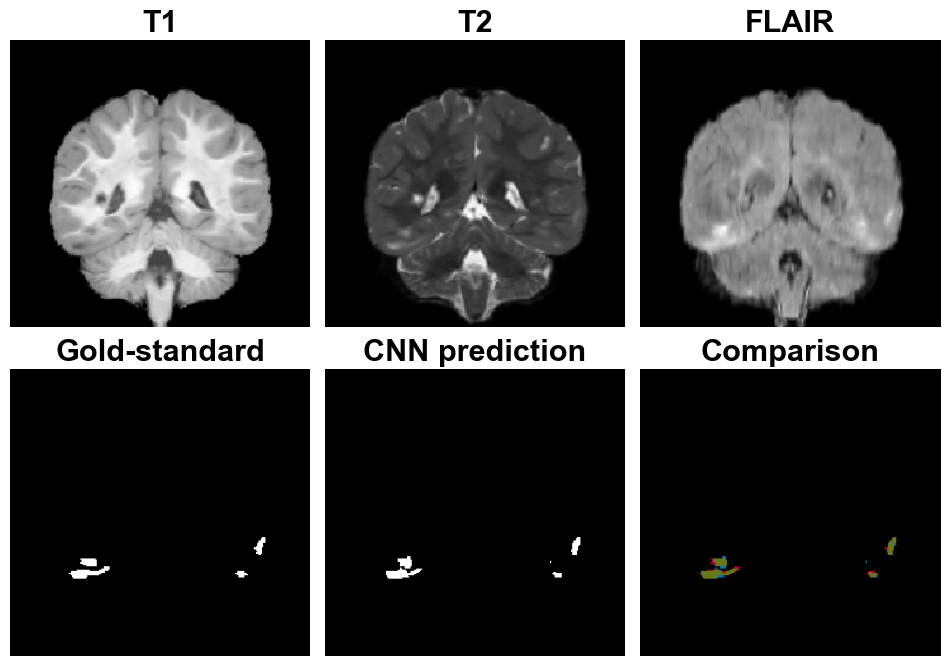

In [37]:
# Test 3 figure of 2D slice
test_T1_img = X_test_full_images_T1[9, :, 158, :]
test_T2_img = X_test_full_images_T2[9, :, 158, :]
test_FLAIR_img = X_test_full_images_FLAIR[9, :, 158, :]
true_mask = Y_test_full_images[9, :, 158, :]
predicted_mask = Y_predictions_full_images[9, :, 158, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


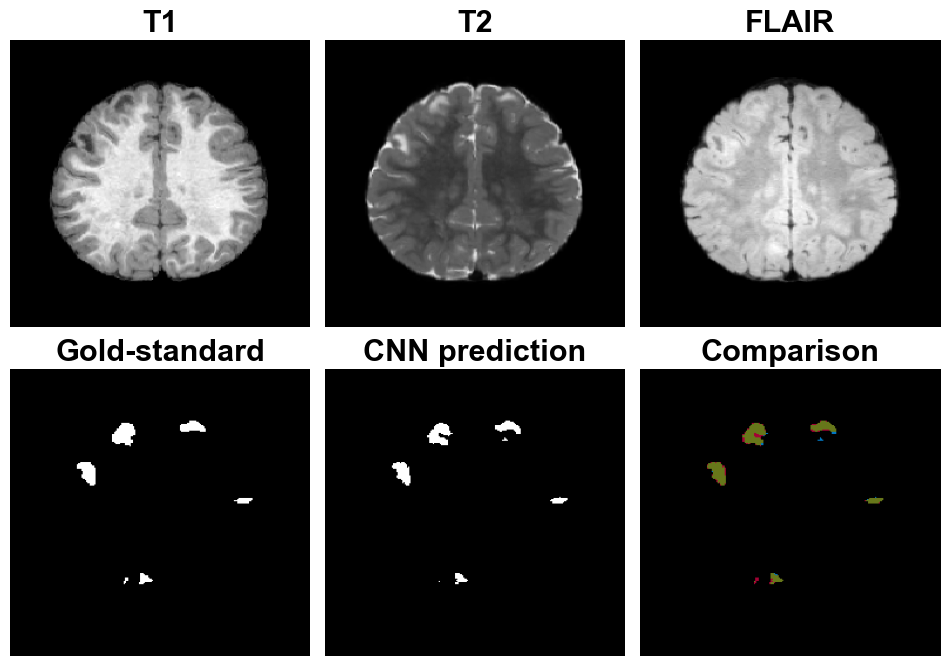

In [38]:
# Test 4 figure of 2D slice
test_T1_img = X_test_full_images_T1[10, :, :, 150]
test_T2_img = X_test_full_images_T2[10, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[10, :, :, 150]
true_mask = Y_test_full_images[10, :, :, 150]
predicted_mask = Y_predictions_full_images[10, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


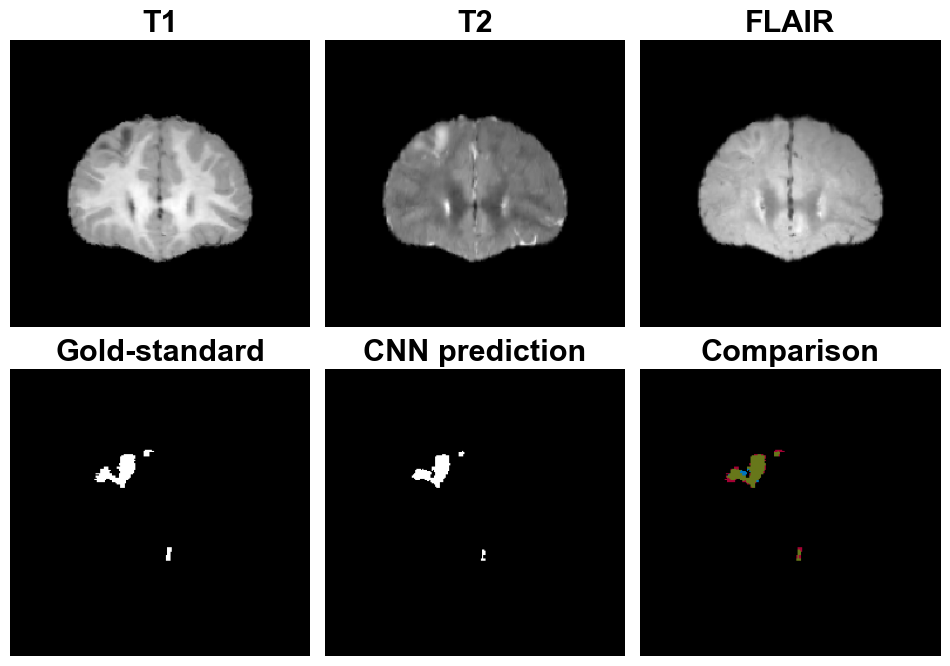

In [39]:
# Test 5 figure of 2D slice
test_T1_img = X_test_full_images_T1[13, :, 70, :]
test_T2_img = X_test_full_images_T2[13, :, 70, :]
test_FLAIR_img = X_test_full_images_FLAIR[13, :, 70, :]
true_mask = Y_test_full_images[13, :, 70, :]
predicted_mask = Y_predictions_full_images[13, :, 70, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


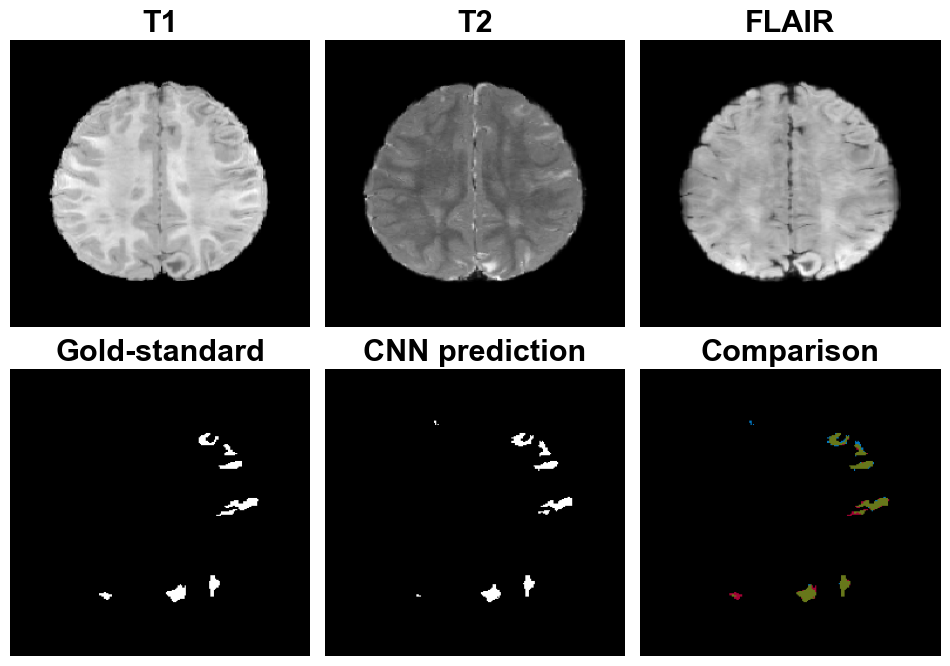

In [40]:
# Test 6 figure of 2D slice
test_T1_img = X_test_full_images_T1[15, :, :, 150]
test_T2_img = X_test_full_images_T2[15, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[15, :, :, 150]
true_mask = Y_test_full_images[15, :, :, 150]
predicted_mask = Y_predictions_full_images[15, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


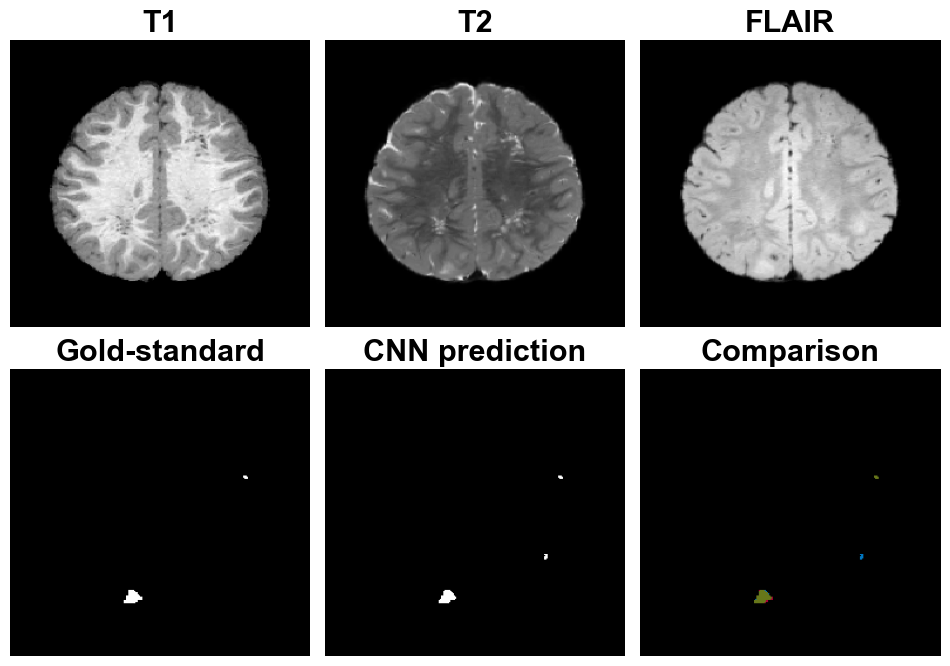

In [41]:
# Test 7 figure of 2D slice
test_T1_img = X_test_full_images_T1[18, :, :, 150]
test_T2_img = X_test_full_images_T2[18, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[18, :, :, 150]
true_mask = Y_test_full_images[18, :, :, 150]
predicted_mask = Y_predictions_full_images[18, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


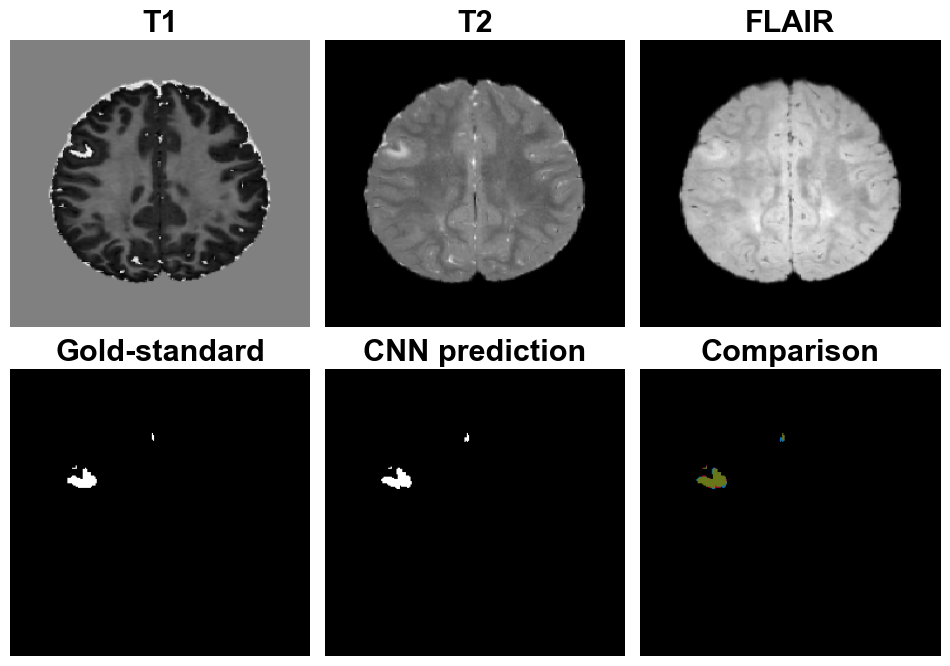

In [42]:
# Test 8 figure of 2D slice
test_T1_img = X_test_full_images_T1[20, :, :, 150]
test_T2_img = X_test_full_images_T2[20, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[20, :, :, 150]
true_mask = Y_test_full_images[20, :, :, 150]
predicted_mask = Y_predictions_full_images[20, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


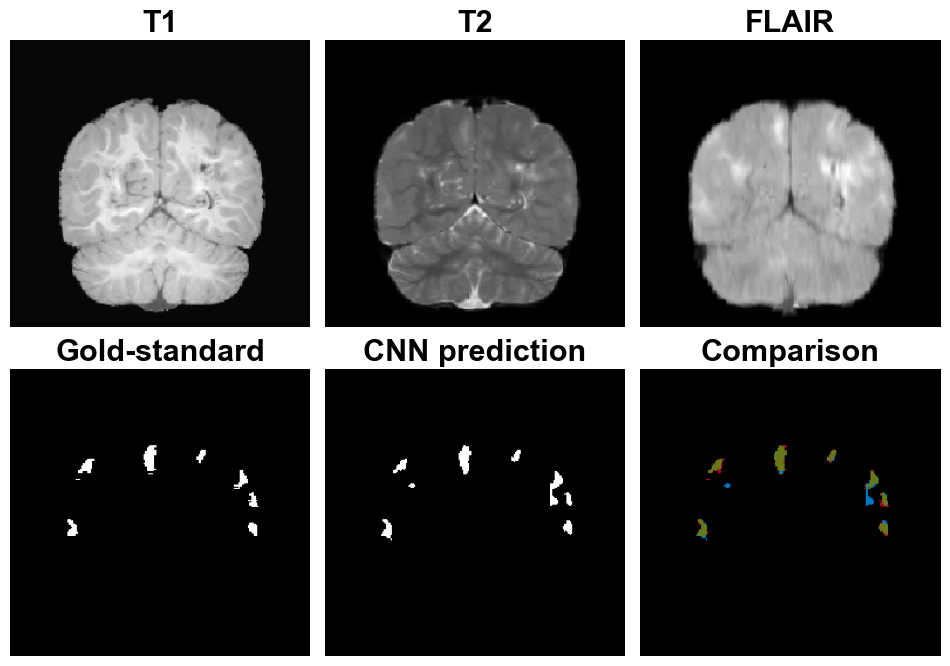

In [43]:
# Test 9 figure of 2D slice
test_T1_img = X_test_full_images_T1[28, :, 174, :]
test_T2_img = X_test_full_images_T2[28, :, 174, :]
test_FLAIR_img = X_test_full_images_FLAIR[28, :, 174, :]
true_mask = Y_test_full_images[28, :, 174, :]
predicted_mask = Y_predictions_full_images[28, :, 174, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


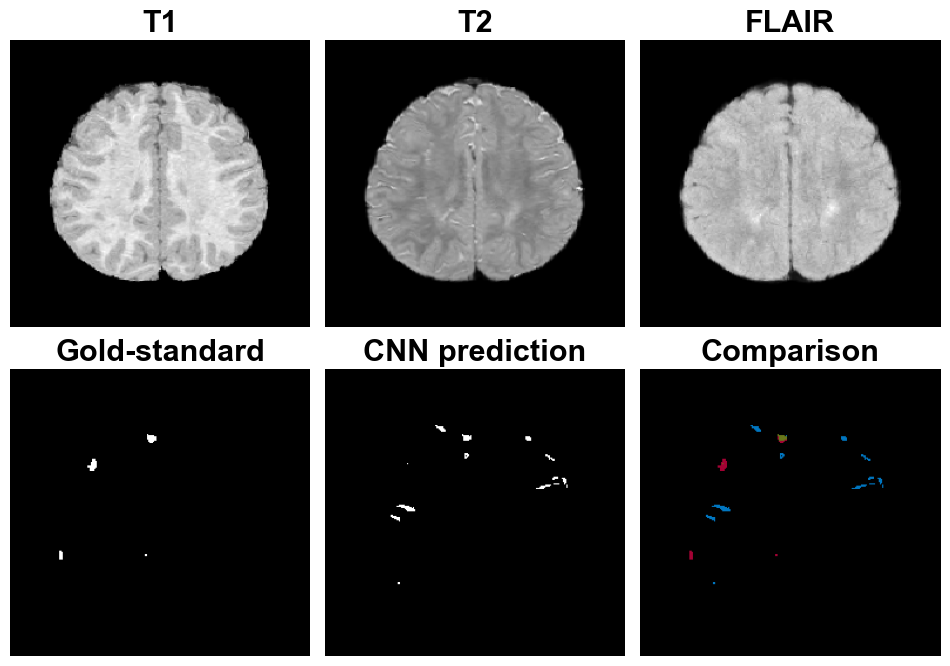

In [44]:
# Test 10 figure of 2D slice
test_T1_img = X_test_full_images_T1[25, :, :, 150]
test_T2_img = X_test_full_images_T2[25, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[25, :, :, 150]
true_mask = Y_test_full_images[25, :, :, 150]
predicted_mask = Y_predictions_full_images[25, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


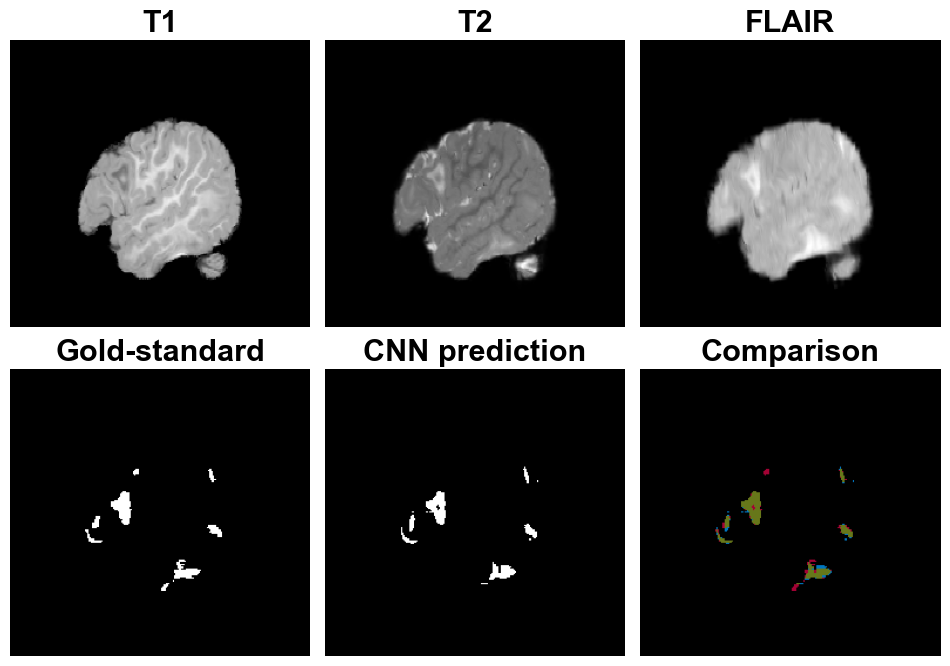

In [45]:
# Test 11 figure of 2D slice
test_T1_img = X_test_full_images_T1[28, 56, :, :]
test_T2_img = X_test_full_images_T2[28, 56, :, :]
test_FLAIR_img = X_test_full_images_FLAIR[28, 56, :, :]
true_mask = Y_test_full_images[28, 56, :, :]
predicted_mask = Y_predictions_full_images[28, 56, :, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


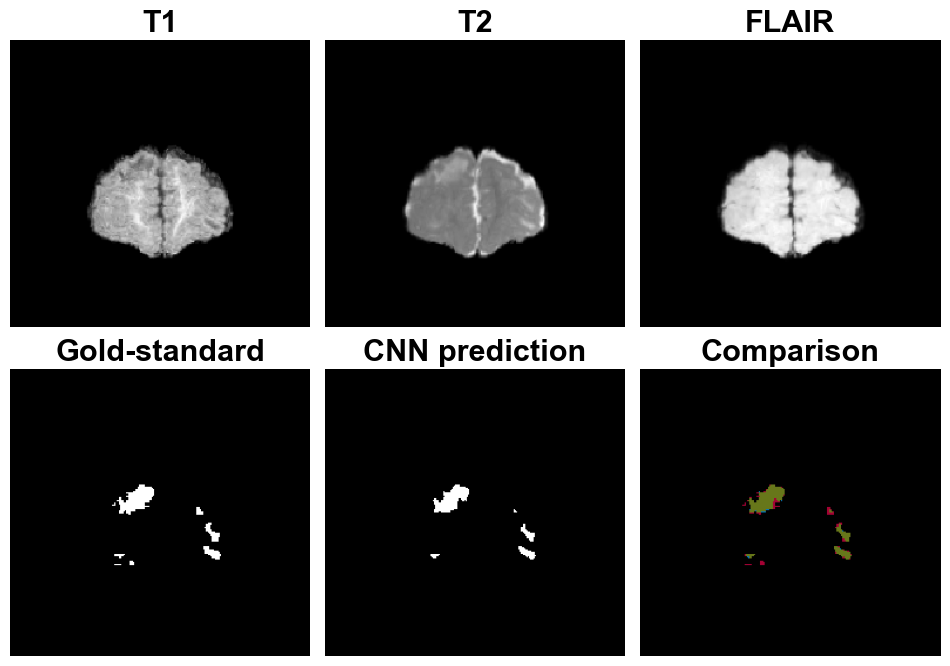

In [46]:
# Test 12 figure of 2D slice
test_T1_img = X_test_full_images_T1[29, :, 41, :]
test_T2_img = X_test_full_images_T2[29, :, 41, :]
test_FLAIR_img = X_test_full_images_FLAIR[29, :, 41, :]
true_mask = Y_test_full_images[29, :, 41, :]
predicted_mask = Y_predictions_full_images[29, :, 41, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


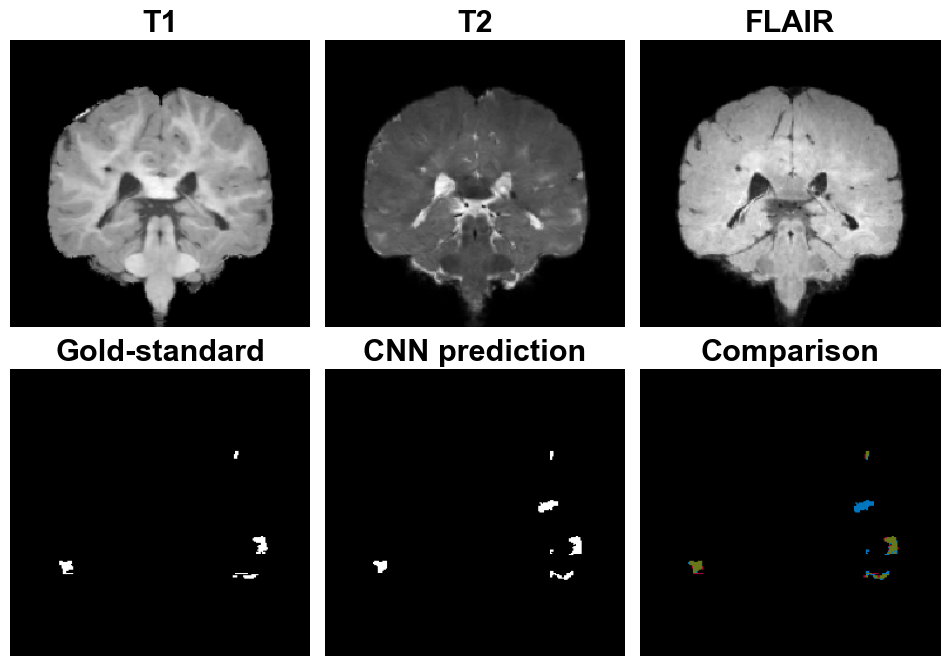

In [47]:
# Test 13 figure of 2D slice
test_T1_img = X_test_full_images_T1[31, :, 146, :]
test_T2_img = X_test_full_images_T2[31, :, 146, :]
test_FLAIR_img = X_test_full_images_FLAIR[31, :, 146, :]
true_mask = Y_test_full_images[31, :, 146, :]
predicted_mask = Y_predictions_full_images[31, :, 146, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


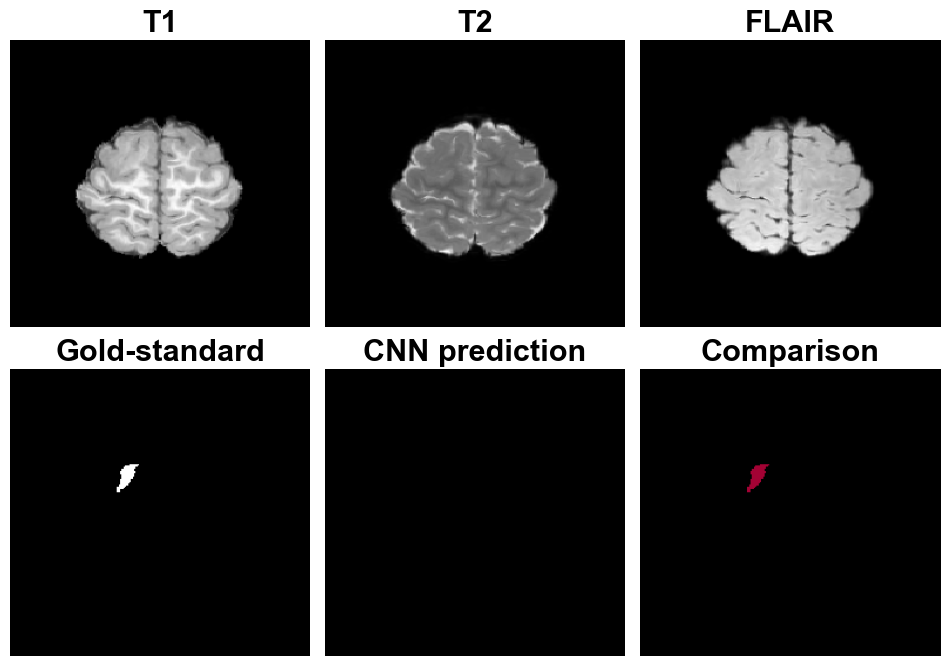

In [48]:
# Test 14 figure of 2D slice
test_T1_img = X_test_full_images_T1[32, :, :, 187]
test_T2_img = X_test_full_images_T2[32, :, :, 187]
test_FLAIR_img = X_test_full_images_FLAIR[32, :, :, 187]
true_mask = Y_test_full_images[32, :, :, 187]
predicted_mask = Y_predictions_full_images[32, :, :, 187]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


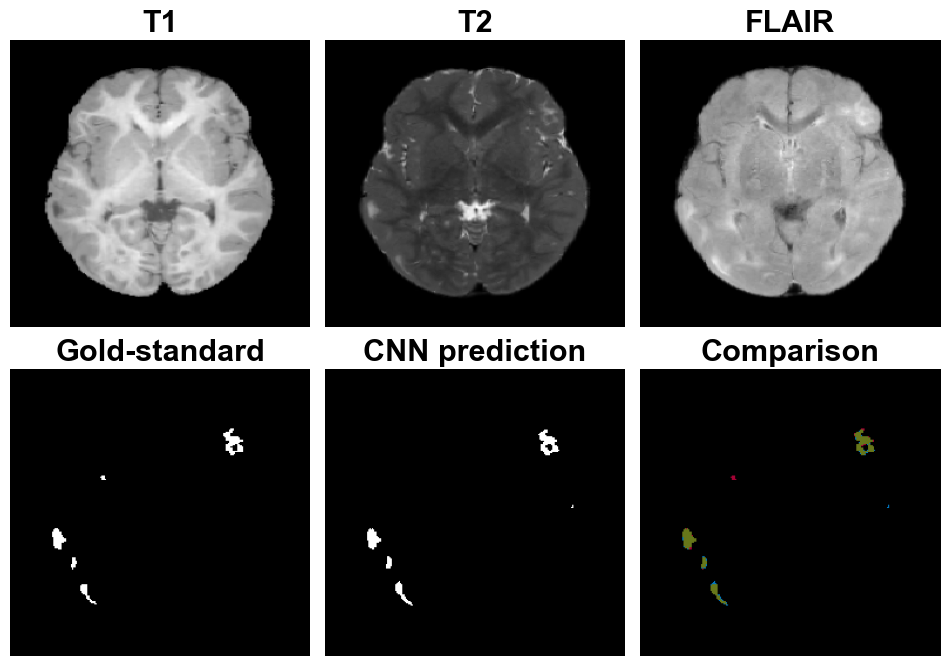

In [49]:
# Test 15 figure of 2D slice
test_T1_img = X_test_full_images_T1[33, :, :, 101]
test_T2_img = X_test_full_images_T2[33, :, :, 101]
test_FLAIR_img = X_test_full_images_FLAIR[33, :, :, 101]
true_mask = Y_test_full_images[33, :, :, 101]
predicted_mask = Y_predictions_full_images[33, :, :, 101]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


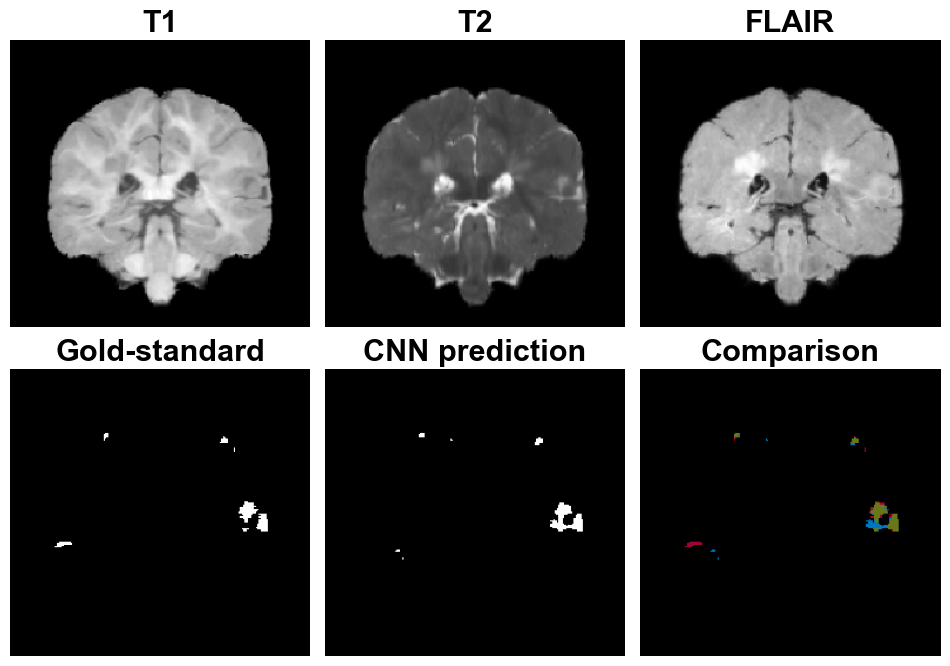

In [50]:
# Test 16 figure of 2D slice
test_T1_img = X_test_full_images_T1[35, :, 146, :]
test_T2_img = X_test_full_images_T2[35, :, 146, :]
test_FLAIR_img = X_test_full_images_FLAIR[35, :, 146, :]
true_mask = Y_test_full_images[35, :, 146, :]
predicted_mask = Y_predictions_full_images[35, :, 146, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


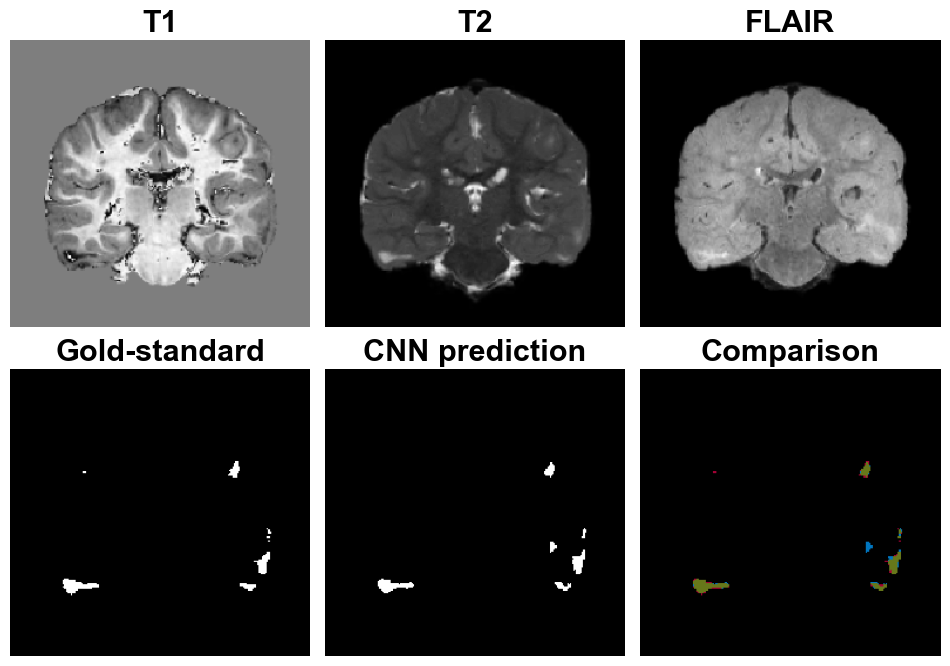

In [51]:
# Test 17 figure of 2D slice
test_T1_img = X_test_full_images_T1[36, :, 136, :]
test_T2_img = X_test_full_images_T2[36, :, 136, :]
test_FLAIR_img = X_test_full_images_FLAIR[36, :, 136, :]
true_mask = Y_test_full_images[36, :, 136, :]
predicted_mask = Y_predictions_full_images[36, :, 136, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


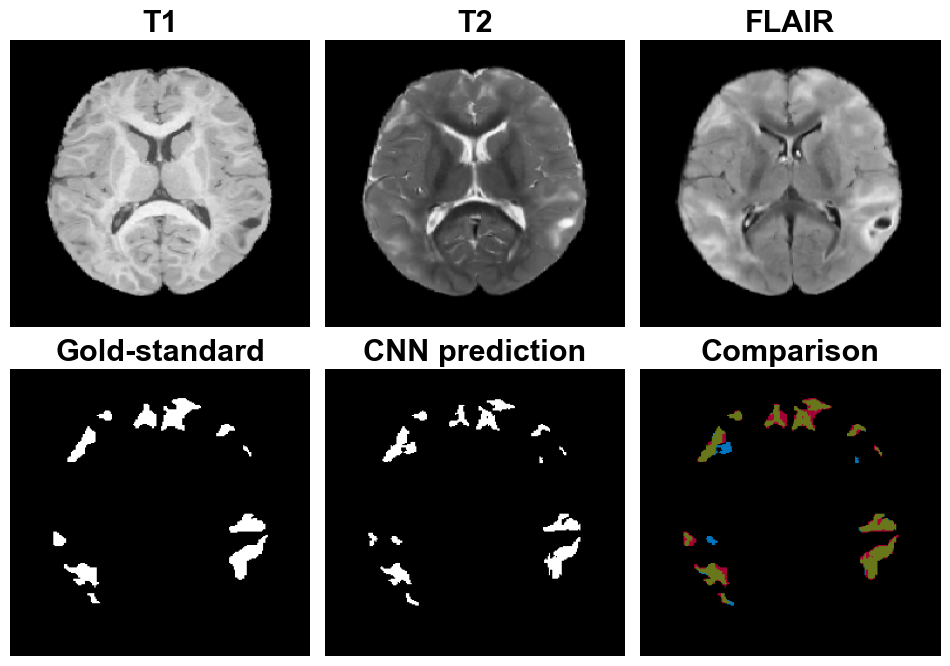

In [52]:
# Test 18 figure of 2D slice
test_T1_img = X_test_full_images_T1[37, :, :, 118]
test_T2_img = X_test_full_images_T2[37, :, :, 118]
test_FLAIR_img = X_test_full_images_FLAIR[37, :, :, 118]
true_mask = Y_test_full_images[37, :, :, 118]
predicted_mask = Y_predictions_full_images[37, :, :, 118]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


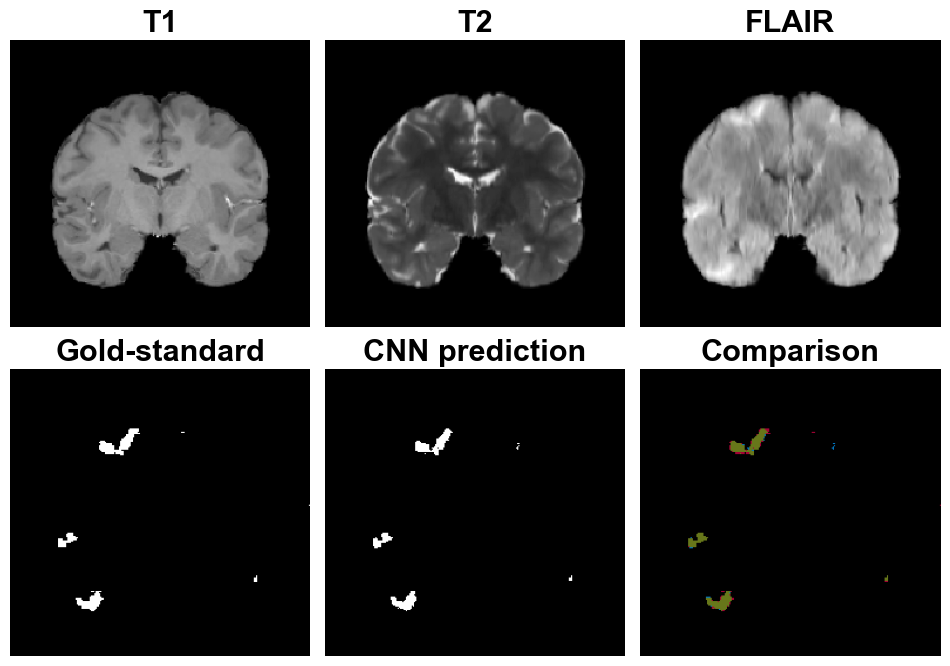

In [53]:
# Test 19 figure of 2D slice
test_T1_img = X_test_full_images_T1[40, :, 116, :]
test_T2_img = X_test_full_images_T2[40, :, 116, :]
test_FLAIR_img = X_test_full_images_FLAIR[40, :, 116, :]
true_mask = Y_test_full_images[40, :, 116, :]
predicted_mask = Y_predictions_full_images[40, :, 116, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


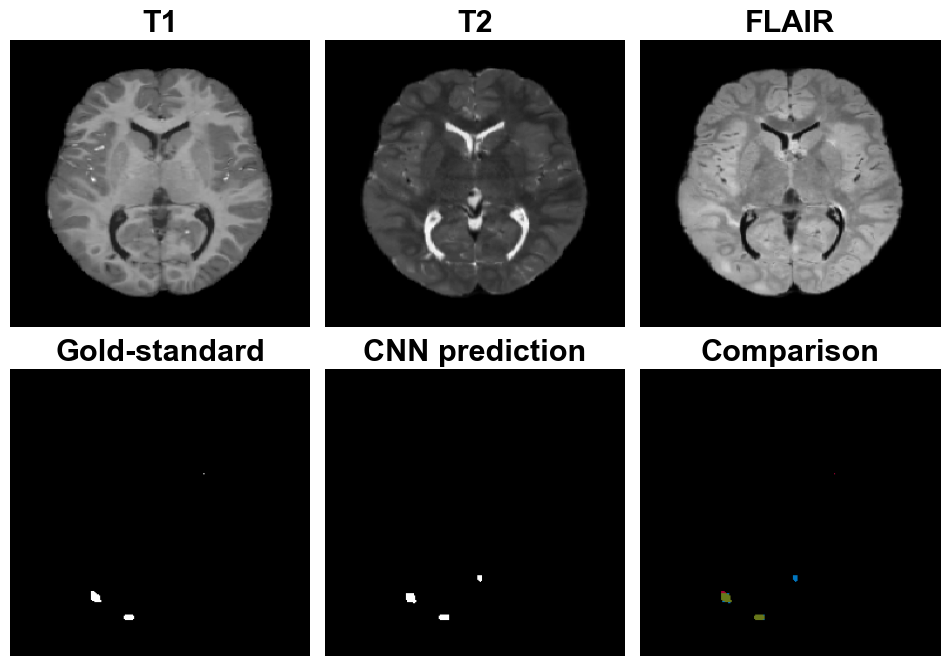

In [54]:
# Test 20 figure of 2D slice
test_T1_img = X_test_full_images_T1[45, :, :, 112]
test_T2_img = X_test_full_images_T2[45, :, :, 112]
test_FLAIR_img = X_test_full_images_FLAIR[45, :, :, 112]
true_mask = Y_test_full_images[45, :, :, 112]
predicted_mask = Y_predictions_full_images[45, :, :, 112]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [163/255, 2/255, 52/255]
comparison_image[predicted_mask == 1] = [0/255, 118/255, 192/255]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [103/255, 119/255, 26/255]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

## Extract parcellation masks and calculate tuber volume (total and per region)

In [55]:
####################################GRAY MATTER MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
gray_matter_mask = sitk.ReadImage('/home/ch134560/data/masks/gray_matter_total_lobes_binarized.nii')
gray_matter_mask = sitk.GetArrayFromImage(gray_matter_mask)

# Resize for consistency
gray_matter_mask = np.float32(np.flip(np.transpose(gray_matter_mask, [2, 1, 0]), axis=1))
gray_matter_mask = scipy.ndimage.zoom(gray_matter_mask, zoom=(SX_img/gray_matter_mask.shape[0], SY_img/gray_matter_mask.shape[1], SZ_img/gray_matter_mask.shape[2]), order=0)




####################################RIGHT OCCIPITAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_occipital_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Occipital_Lobe_mask.nii.gz')
R_occipital_mask = sitk.GetArrayFromImage(R_occipital_mask)

# Resize for consistency
R_occipital_mask = np.float32(np.flip(np.transpose(R_occipital_mask, [2, 1, 0]), axis=1))
R_occipital_mask = scipy.ndimage.zoom(R_occipital_mask, zoom=(SX_img/R_occipital_mask.shape[0], SY_img/R_occipital_mask.shape[1], SZ_img/R_occipital_mask.shape[2]), order=0)




####################################LEFT OCCIPITAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_occipital_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Occipital_Lobe_mask.nii.gz')
L_occipital_mask = sitk.GetArrayFromImage(L_occipital_mask)

# Resize for consistency
L_occipital_mask = np.float32(np.flip(np.transpose(L_occipital_mask, [2, 1, 0]), axis=1))
L_occipital_mask = scipy.ndimage.zoom(L_occipital_mask, zoom=(SX_img/L_occipital_mask.shape[0], SY_img/L_occipital_mask.shape[1], SZ_img/L_occipital_mask.shape[2]), order=0)




####################################RIGHT PARIETAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_parietal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Parietal_Lobe_mask.nii.gz')
R_parietal_mask = sitk.GetArrayFromImage(R_parietal_mask)

# Resize for consistency
R_parietal_mask = np.float32(np.flip(np.transpose(R_parietal_mask, [2, 1, 0]), axis=1))
R_parietal_mask = scipy.ndimage.zoom(R_parietal_mask, zoom=(SX_img/R_parietal_mask.shape[0], SY_img/R_parietal_mask.shape[1], SZ_img/R_parietal_mask.shape[2]), order=0)




####################################LEFT PARIETAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_parietal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Parietal_Lobe_mask.nii.gz')
L_parietal_mask = sitk.GetArrayFromImage(L_parietal_mask)

# Resize for consistency
L_parietal_mask = np.float32(np.flip(np.transpose(L_parietal_mask, [2, 1, 0]), axis=1))
L_parietal_mask = scipy.ndimage.zoom(L_parietal_mask, zoom=(SX_img/L_parietal_mask.shape[0], SY_img/L_parietal_mask.shape[1], SZ_img/L_parietal_mask.shape[2]), order=0)




####################################RIGHT TEMPORAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_temporal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Temporal_Lobe_mask.nii')
R_temporal_mask = sitk.GetArrayFromImage(R_temporal_mask)

# Resize for consistency
R_temporal_mask = np.float32(np.flip(np.transpose(R_temporal_mask, [2, 1, 0]), axis=1))
R_temporal_mask = scipy.ndimage.zoom(R_temporal_mask, zoom=(SX_img/R_temporal_mask.shape[0], SY_img/R_temporal_mask.shape[1], SZ_img/R_temporal_mask.shape[2]), order=0)




####################################LEFT TEMPORAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_temporal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Temporal_Lobe_mask.nii')
L_temporal_mask = sitk.GetArrayFromImage(L_temporal_mask)

# Resize for consistency
L_temporal_mask = np.float32(np.flip(np.transpose(L_temporal_mask, [2, 1, 0]), axis=1))
L_temporal_mask = scipy.ndimage.zoom(L_temporal_mask, zoom=(SX_img/L_temporal_mask.shape[0], SY_img/L_temporal_mask.shape[1], SZ_img/L_temporal_mask.shape[2]), order=0)




####################################RIGHT FRONTAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_frontal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Frontal_Lobe_mask.nii.gz')
R_frontal_mask = sitk.GetArrayFromImage(R_frontal_mask)

# Resize for consistency
R_frontal_mask = np.float32(np.flip(np.transpose(R_frontal_mask, [2, 1, 0]), axis=1))
R_frontal_mask = scipy.ndimage.zoom(R_frontal_mask, zoom=(SX_img/R_frontal_mask.shape[0], SY_img/R_frontal_mask.shape[1], SZ_img/R_frontal_mask.shape[2]), order=0)




####################################LEFT FRONTAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_frontal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Frontal_Lobe_mask.nii.gz')
L_frontal_mask = sitk.GetArrayFromImage(L_frontal_mask)

# Resize for consistency
L_frontal_mask = np.float32(np.flip(np.transpose(L_frontal_mask, [2, 1, 0]), axis=1))
L_frontal_mask = scipy.ndimage.zoom(L_frontal_mask, zoom=(SX_img/L_frontal_mask.shape[0], SY_img/L_frontal_mask.shape[1], SZ_img/L_frontal_mask.shape[2]), order=0)

#### Total tuber volume

In [56]:
# Calculate tuber volume
volume_test = [np.sum(Y_test_full_images[i, :, :, :]) for i in range(Y_test_full_images.shape[0])]
volume_prediction = [np.sum(Y_predictions_full_images[i, :, :, :]) for i in range(Y_predictions_full_images.shape[0])]

In [57]:
# Calculate Spearman correlation coefficient
p_value_Spearman = stats.spearmanr(volume_test, volume_prediction)[1]
stats.spearmanr(volume_test, volume_prediction)

SignificanceResult(statistic=0.9834997828918801, pvalue=8.28557986529946e-36)

In [58]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test, volume_prediction)[0]
count = len(volume_test)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9705938241155342, 0.9834997828918801, 0.9907680333259808)

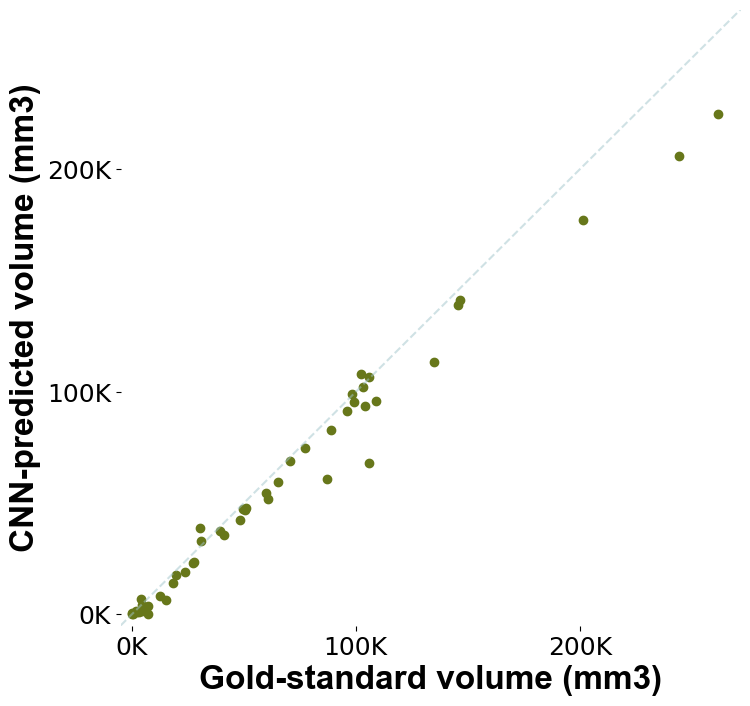

In [59]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test, volume_prediction, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test), min(volume_prediction)) -5000), (max(max(volume_test), max(volume_prediction)) + 10000) ) 
plt.ylim( (min(min(volume_test), min(volume_prediction)) -5000), (max(max(volume_test), max(volume_prediction)) + 10000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in gray matter

In [60]:
# Calculate tuber volume in gray matter
volume_test_gray_matter = [np.sum(np.multiply(gray_matter_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_gray_matter = [np.sum(np.multiply(gray_matter_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_gray_matter = np.sum(gray_matter_mask)
gold_standard_proportion_gray_matter = [round(volume_test_gray_matter[i] / total_volume_gray_matter, 6) for i in range(len(volume_test_gray_matter))]
prediction_proportion_gray_matter = [round(volume_prediction_gray_matter[i] / total_volume_gray_matter, 6) for i in range(len(volume_prediction_gray_matter))]

In [61]:
# Calculate Spearman correlation coefficient
p_value_Spearman_gray_matter = stats.spearmanr(volume_test_gray_matter, volume_prediction_gray_matter)[1]
stats.spearmanr(volume_test_gray_matter, volume_prediction_gray_matter)

SignificanceResult(statistic=0.9875973624284562, pvalue=1.218342544939781e-38)

In [62]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_gray_matter, volume_prediction_gray_matter)[0]
count = len(volume_test_gray_matter)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9778606299818507, 0.9875973624284562, 0.9930669616973444)

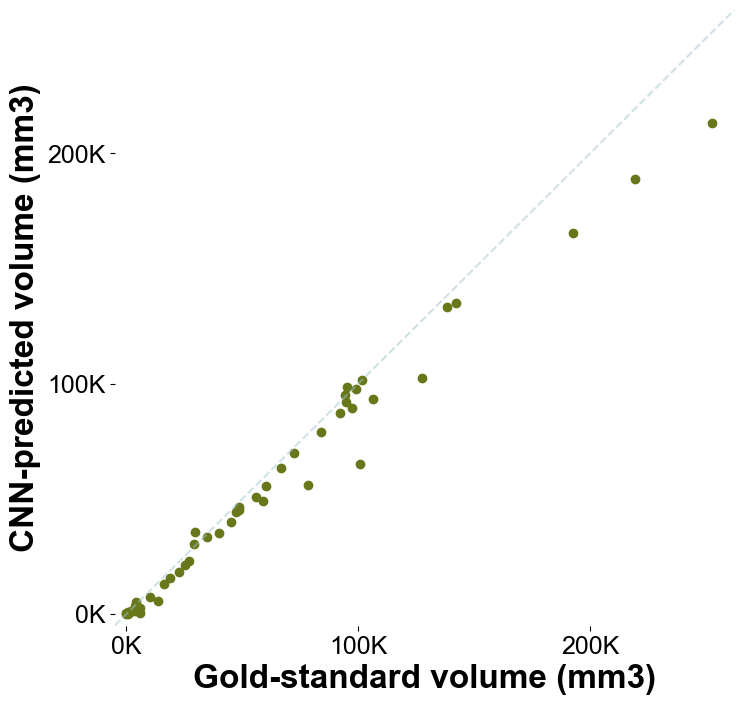

In [63]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_gray_matter, volume_prediction_gray_matter, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_gray_matter), min(volume_prediction_gray_matter)) -5000), (max(max(volume_test_gray_matter), max(volume_prediction_gray_matter)) + 10000) ) 
plt.ylim( (min(min(volume_test_gray_matter), min(volume_prediction_gray_matter)) -5000), (max(max(volume_test_gray_matter), max(volume_prediction_gray_matter)) + 10000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in right occipital lobe

In [64]:
# Calculate tuber volume in right occipital lobe
volume_test_R_occipital = [np.sum(np.multiply(R_occipital_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_R_occipital = [np.sum(np.multiply(R_occipital_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_R_occipital = np.sum(R_occipital_mask)
gold_standard_proportion_R_occipital = [round(volume_test_R_occipital[i] / total_volume_R_occipital, 6) for i in range(len(volume_test_R_occipital))]
prediction_proportion_R_occipital = [round(volume_prediction_R_occipital[i] / total_volume_R_occipital, 6) for i in range(len(volume_prediction_R_occipital))]

In [65]:
# Calculate Spearman correlation coefficient
p_value_Spearman_R_occipital = stats.spearmanr(volume_test_R_occipital, volume_prediction_R_occipital)[1]
stats.spearmanr(volume_test_R_occipital, volume_prediction_R_occipital)

SignificanceResult(statistic=0.9821704711910014, pvalue=4.854486002239272e-35)

In [66]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_R_occipital, volume_prediction_R_occipital)[0]
count = len(volume_test_R_occipital)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9682414137582791, 0.9821704711910014, 0.990021329930383)

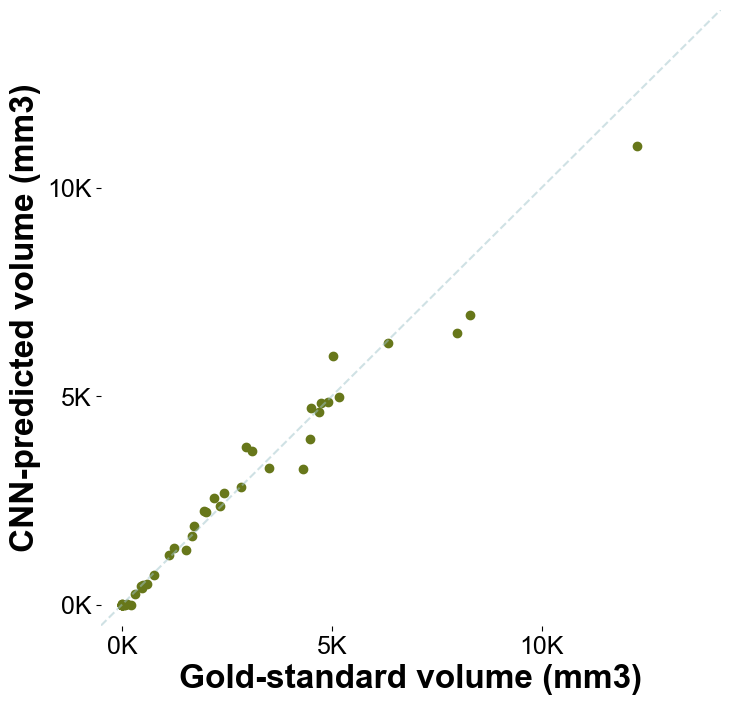

In [67]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_R_occipital, volume_prediction_R_occipital, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_R_occipital), min(volume_prediction_R_occipital)) -500), (max(max(volume_test_R_occipital), max(volume_prediction_R_occipital)) + 2000) ) 
plt.ylim( (min(min(volume_test_R_occipital), min(volume_prediction_R_occipital)) -500), (max(max(volume_test_R_occipital), max(volume_prediction_R_occipital)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in left occipital lobe

In [68]:
# Calculate tuber volume in left occipital lobe
volume_test_L_occipital = [np.sum(np.multiply(L_occipital_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_L_occipital = [np.sum(np.multiply(L_occipital_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_L_occipital = np.sum(L_occipital_mask)
gold_standard_proportion_L_occipital = [round(volume_test_L_occipital[i] / total_volume_L_occipital, 6) for i in range(len(volume_test_L_occipital))]
prediction_proportion_L_occipital = [round(volume_prediction_L_occipital[i] / total_volume_L_occipital, 6) for i in range(len(volume_prediction_L_occipital))]

In [69]:
# Calculate Spearman correlation coefficient
p_value_Spearman_L_occipital = stats.spearmanr(volume_test_L_occipital, volume_prediction_L_occipital)[1]
stats.spearmanr(volume_test_L_occipital, volume_prediction_L_occipital)

SignificanceResult(statistic=0.9914948843480114, pvalue=2.1653167142855574e-42)

In [70]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_L_occipital, volume_prediction_L_occipital)[0]
count = len(volume_test_L_occipital)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9847945068670669, 0.9914948843480114, 0.9952497729692672)

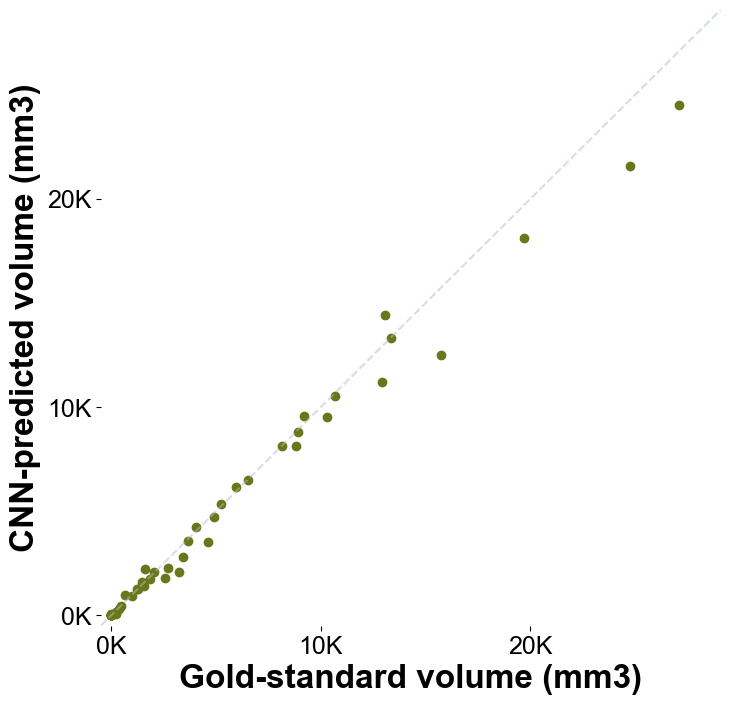

In [71]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_L_occipital, volume_prediction_L_occipital, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_L_occipital), min(volume_prediction_L_occipital)) -500), (max(max(volume_test_L_occipital), max(volume_prediction_L_occipital)) + 2000) ) 
plt.ylim( (min(min(volume_test_L_occipital), min(volume_prediction_L_occipital)) -500), (max(max(volume_test_L_occipital), max(volume_prediction_L_occipital)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in right parietal lobe

In [72]:
# Calculate tuber volume in right parietal lobe
volume_test_R_parietal = [np.sum(np.multiply(R_parietal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_R_parietal = [np.sum(np.multiply(R_parietal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_R_parietal = np.sum(R_parietal_mask)
gold_standard_proportion_R_parietal = [round(volume_test_R_parietal[i] / total_volume_R_parietal, 6) for i in range(len(volume_test_R_parietal))]
prediction_proportion_R_parietal = [round(volume_prediction_R_parietal[i] / total_volume_R_parietal, 6) for i in range(len(volume_prediction_R_parietal))]

In [73]:
# Calculate Spearman correlation coefficient
p_value_Spearman_R_parietal = stats.spearmanr(volume_test_R_parietal, volume_prediction_R_parietal)[1]
stats.spearmanr(volume_test_R_parietal, volume_prediction_R_parietal)

SignificanceResult(statistic=0.9828935101754094, pvalue=1.8878358025124488e-35)

In [74]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_R_parietal, volume_prediction_R_parietal)[0]
count = len(volume_test_R_parietal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9695206305518907, 0.9828935101754094, 0.9904275314000036)

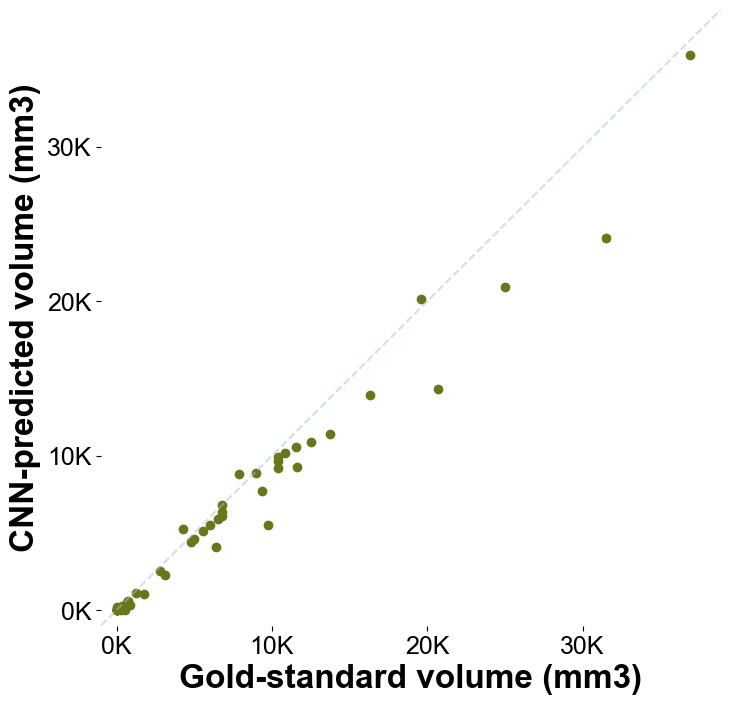

In [75]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_R_parietal, volume_prediction_R_parietal, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_R_parietal), min(volume_prediction_R_parietal)) -1000), (max(max(volume_test_R_parietal), max(volume_prediction_R_parietal)) + 2000) ) 
plt.ylim( (min(min(volume_test_R_parietal), min(volume_prediction_R_parietal)) -1000), (max(max(volume_test_R_parietal), max(volume_prediction_R_parietal)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in left parietal lobe

In [76]:
# Calculate tuber volume in left parietal lobe
volume_test_L_parietal = [np.sum(np.multiply(L_parietal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_L_parietal = [np.sum(np.multiply(L_parietal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_L_parietal = np.sum(L_parietal_mask)
gold_standard_proportion_L_parietal = [round(volume_test_L_parietal[i] / total_volume_L_parietal, 6) for i in range(len(volume_test_L_parietal))]
prediction_proportion_L_parietal = [round(volume_prediction_L_parietal[i] / total_volume_L_parietal, 6) for i in range(len(volume_prediction_L_parietal))]

In [77]:
# Calculate Spearman correlation coefficient
p_value_Spearman_L_parietal = stats.spearmanr(volume_test_L_parietal, volume_prediction_L_parietal)[1]
stats.spearmanr(volume_test_L_parietal, volume_prediction_L_parietal)

SignificanceResult(statistic=0.9886254926804934, pvalue=1.6831731926718763e-39)

In [78]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_L_parietal, volume_prediction_L_parietal)[0]
count = len(volume_test_L_parietal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9796876487766434, 0.9886254926804934, 0.9936431336367711)

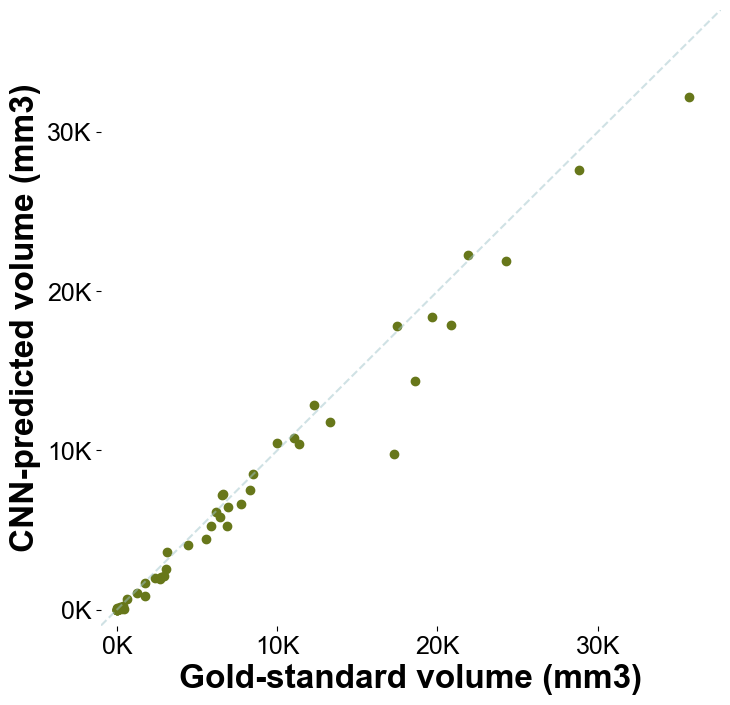

In [79]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_L_parietal, volume_prediction_L_parietal, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_L_parietal), min(volume_prediction_L_parietal)) -1000), (max(max(volume_test_L_parietal), max(volume_prediction_L_parietal)) + 2000) ) 
plt.ylim( (min(min(volume_test_L_parietal), min(volume_prediction_L_parietal)) -1000), (max(max(volume_test_L_parietal), max(volume_prediction_L_parietal)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in right temporal lobe

In [80]:
# Calculate tuber volume in right temporal lobe
volume_test_R_temporal = [np.sum(np.multiply(R_temporal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_R_temporal = [np.sum(np.multiply(R_temporal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_R_temporal = np.sum(R_temporal_mask)
gold_standard_proportion_R_temporal = [round(volume_test_R_temporal[i] / total_volume_R_temporal, 6) for i in range(len(volume_test_R_temporal))]
prediction_proportion_R_temporal = [round(volume_prediction_R_temporal[i] / total_volume_R_temporal, 6) for i in range(len(volume_prediction_R_temporal))]

In [81]:
# Calculate Spearman correlation coefficient
p_value_Spearman_R_temporal = stats.spearmanr(volume_test_R_temporal, volume_prediction_R_temporal)[1]
stats.spearmanr(volume_test_R_temporal, volume_prediction_R_temporal)

SignificanceResult(statistic=0.9671040788900441, pvalue=5.425002527119742e-29)

In [82]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_R_temporal, volume_prediction_R_temporal)[0]
count = len(volume_test_R_temporal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9417505171708789, 0.9671040788900441, 0.9815272804624449)

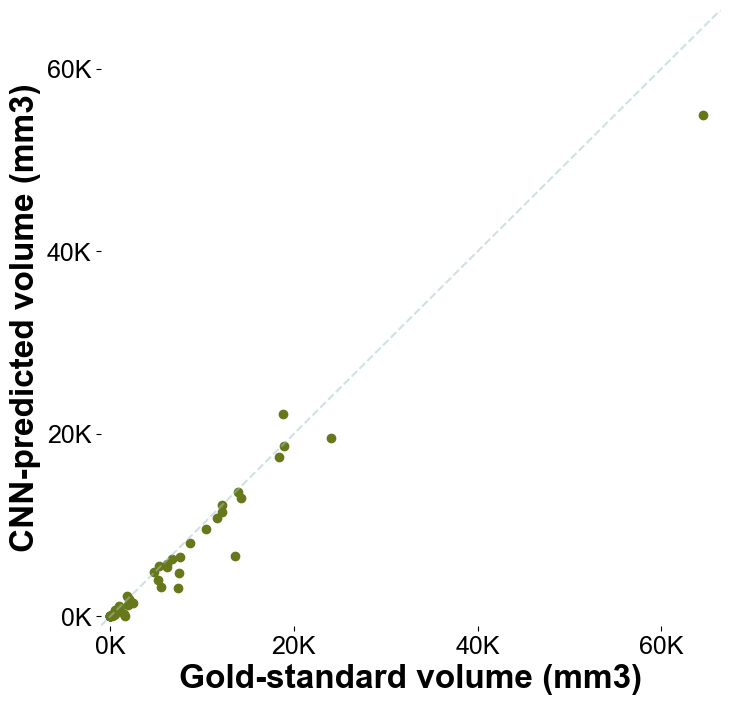

In [83]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_R_temporal, volume_prediction_R_temporal, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_R_temporal), min(volume_prediction_R_temporal)) -1000), (max(max(volume_test_R_temporal), max(volume_prediction_R_temporal)) + 2000) ) 
plt.ylim( (min(min(volume_test_R_temporal), min(volume_prediction_R_temporal)) -1000), (max(max(volume_test_R_temporal), max(volume_prediction_R_temporal)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in left temporal lobe

In [84]:
# Calculate tuber volume in left temporal lobe
volume_test_L_temporal = [np.sum(np.multiply(L_temporal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_L_temporal = [np.sum(np.multiply(L_temporal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_L_temporal = np.sum(L_temporal_mask)
gold_standard_proportion_L_temporal = [round(volume_test_L_temporal[i] / total_volume_L_temporal, 6) for i in range(len(volume_test_L_temporal))]
prediction_proportion_L_temporal = [round(volume_prediction_L_temporal[i] / total_volume_L_temporal, 6) for i in range(len(volume_prediction_L_temporal))]

In [85]:
# Calculate Spearman correlation coefficient
p_value_Spearman_L_temporal = stats.spearmanr(volume_test_L_temporal, volume_prediction_L_temporal)[1]
stats.spearmanr(volume_test_L_temporal, volume_prediction_L_temporal)

SignificanceResult(statistic=0.935853846902846, pvalue=1.8143132222599911e-22)

In [86]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_L_temporal, volume_prediction_L_temporal)[0]
count = len(volume_test_L_temporal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.8877889998011993, 0.935853846902846, 0.9637260360457759)

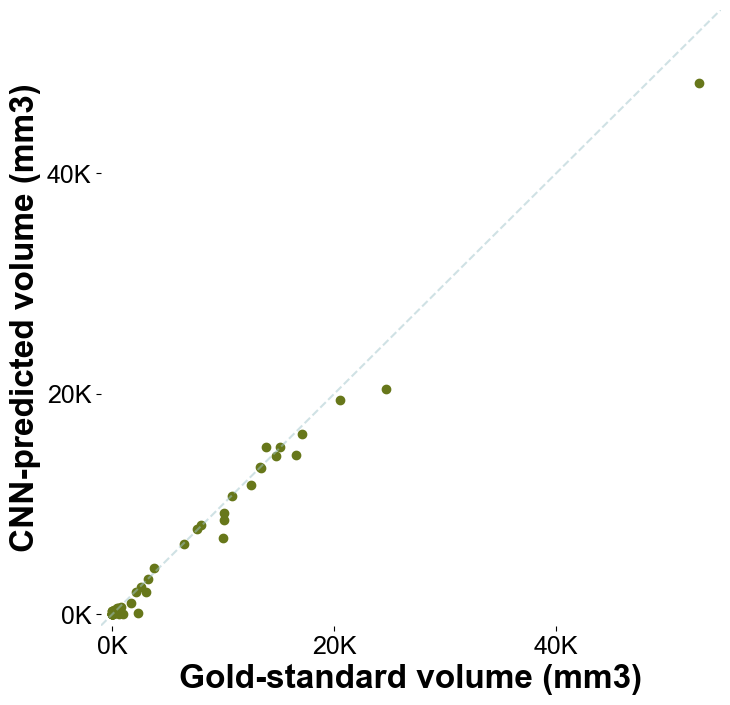

In [87]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_L_temporal, volume_prediction_L_temporal, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_L_temporal), min(volume_prediction_L_temporal)) -1000), (max(max(volume_test_L_temporal), max(volume_prediction_L_temporal)) + 2000) ) 
plt.ylim( (min(min(volume_test_L_temporal), min(volume_prediction_L_temporal)) -1000), (max(max(volume_test_L_temporal), max(volume_prediction_L_temporal)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in right frontal lobe

In [88]:
# Calculate tuber volume in right frontal lobe
volume_test_R_frontal = [np.sum(np.multiply(R_frontal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_R_frontal = [np.sum(np.multiply(R_frontal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_R_frontal = np.sum(R_frontal_mask)
gold_standard_proportion_R_frontal = [round(volume_test_R_frontal[i] / total_volume_R_frontal, 6) for i in range(len(volume_test_R_frontal))]
prediction_proportion_R_frontal = [round(volume_prediction_R_frontal[i] / total_volume_R_frontal, 6) for i in range(len(volume_prediction_R_frontal))]

In [89]:
# Calculate Spearman correlation coefficient
p_value_Spearman_R_frontal = stats.spearmanr(volume_test_R_frontal, volume_prediction_R_frontal)[1]
stats.spearmanr(volume_test_R_frontal, volume_prediction_R_frontal)

SignificanceResult(statistic=0.9727785919774196, pvalue=7.403216328717288e-31)

In [90]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_R_frontal, volume_prediction_R_frontal)[0]
count = len(volume_test_R_frontal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9516910887540877, 0.9727785919774196, 0.9847331153931672)

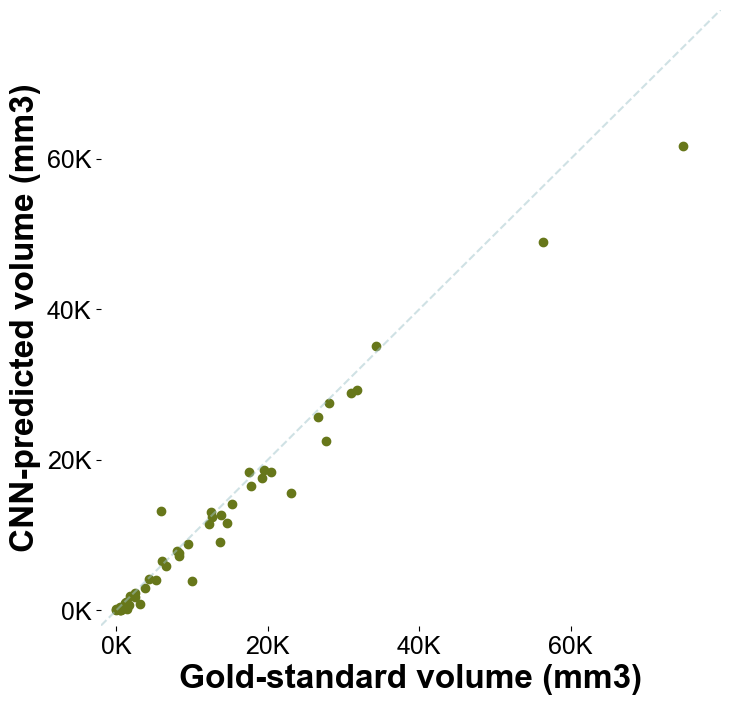

In [91]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_R_frontal, volume_prediction_R_frontal, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_R_frontal), min(volume_prediction_R_frontal)) -2000), (max(max(volume_test_R_frontal), max(volume_prediction_R_frontal)) + 5000) ) 
plt.ylim( (min(min(volume_test_R_frontal), min(volume_prediction_R_frontal)) -2000), (max(max(volume_test_R_frontal), max(volume_prediction_R_frontal)) + 5000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Tuber volume in left frontal lobe

In [92]:
# Calculate tuber volume in left frontal lobe
volume_test_L_frontal = [np.sum(np.multiply(L_frontal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_L_frontal = [np.sum(np.multiply(L_frontal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_L_frontal = np.sum(L_frontal_mask)
gold_standard_proportion_L_frontal = [round(volume_test_L_frontal[i] / total_volume_L_frontal, 6) for i in range(len(volume_test_L_frontal))]
prediction_proportion_L_frontal = [round(volume_prediction_L_frontal[i] / total_volume_L_frontal, 6) for i in range(len(volume_prediction_L_frontal))]

In [93]:
# Calculate Spearman correlation coefficient
p_value_Spearman_L_frontal = stats.spearmanr(volume_test_L_frontal, volume_prediction_L_frontal)[1]
stats.spearmanr(volume_test_L_frontal, volume_prediction_L_frontal)

SignificanceResult(statistic=0.9662305584303996, pvalue=9.820201599196622e-29)

In [94]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_L_frontal, volume_prediction_L_frontal)[0]
count = len(volume_test_L_frontal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9402242147859102, 0.9662305584303996, 0.9810330617911294)

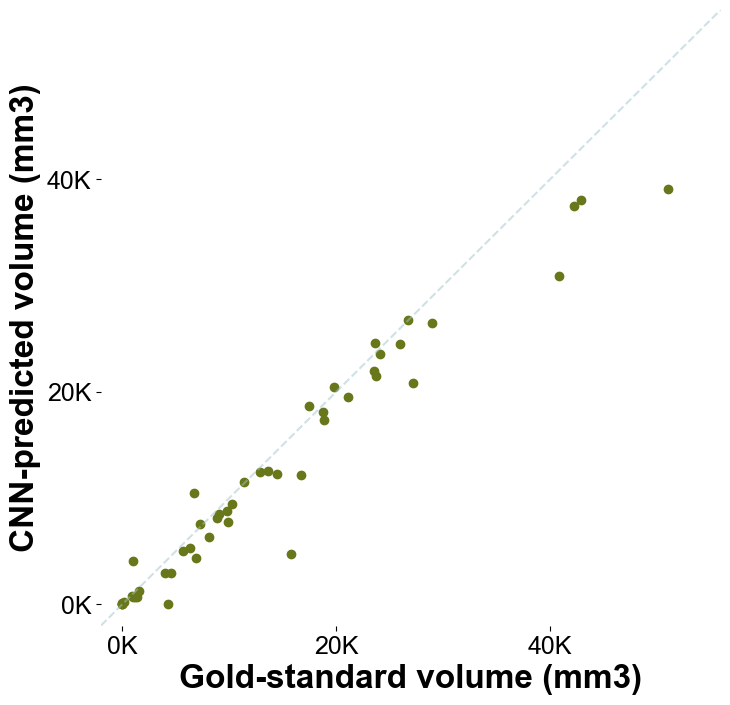

In [95]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_L_frontal, volume_prediction_L_frontal, linewidth=0, marker='o', color='#67771a')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_L_frontal), min(volume_prediction_L_frontal)) -2000), (max(max(volume_test_L_frontal), max(volume_prediction_L_frontal)) + 5000) ) 
plt.ylim( (min(min(volume_test_L_frontal), min(volume_prediction_L_frontal)) -2000), (max(max(volume_test_L_frontal), max(volume_prediction_L_frontal)) + 5000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='#a1c5cb', alpha=0.5)
plt.show()

#### Adjust for multiple comparisons

In [96]:
# False discovery rate adjustmnent
original_p_values = np.array([
    p_value_Spearman,
    p_value_Spearman_gray_matter,
    p_value_Spearman_R_occipital,
    p_value_Spearman_L_occipital,   
    p_value_Spearman_R_parietal,
    p_value_Spearman_L_parietal,
    p_value_Spearman_R_temporal,
    p_value_Spearman_L_temporal,
    p_value_Spearman_R_frontal,
    p_value_Spearman_L_frontal
])

FDR_adjusted_p_values = stats.false_discovery_control(original_p_values, method='bh')

original_p_values, FDR_adjusted_p_values

(array([8.28557987e-36, 1.21834254e-38, 4.85448600e-35, 2.16531671e-42,
        1.88783580e-35, 1.68317319e-39, 5.42500253e-29, 1.81431322e-22,
        7.40321633e-31, 9.82020160e-29]),
 array([2.07139497e-35, 4.06114182e-38, 8.09081000e-35, 2.16531671e-41,
        3.77567161e-35, 8.41586596e-39, 6.78125316e-29, 1.81431322e-22,
        1.05760233e-30, 1.09113351e-28]))

## Export the relevant files

In [97]:
# Loop over the MRIs
for i in range(X_test_full_images_T1.shape[0]):
    # Save the T1 sequence as a .nii.gz file
    T1_MRI = nb.Nifti1Image(X_test_full_images_T1[i, :, :, :], affine=None)
    nb.save(T1_MRI, '/home/ch134560/results/MRI_files/T1_MRI_' + str(i) + '.nii.gz')
    # Save the T2 sequence as a .nii.gz file
    T2_MRI = nb.Nifti1Image(X_test_full_images_T2[i, :, :, :], affine=None)
    nb.save(T2_MRI, '/home/ch134560/results/MRI_files/T2_MRI_' + str(i) + '.nii.gz')
    # Save the FLAIR sequence as a .nii.gz file
    FLAIR_MRI = nb.Nifti1Image(X_test_full_images_FLAIR[i, :, :, :], affine=None)
    nb.save(FLAIR_MRI, '/home/ch134560/results/MRI_files/FLAIR_MRI_' + str(i) + '.nii.gz')
    # Save the true mask sequence as a .nii.gz file
    radiologist_segmentation = nb.Nifti1Image(Y_test_full_images[i, :, :, :], affine=None)
    nb.save(radiologist_segmentation, '/home/ch134560/results/segmentations/radiologist_segmentation_' + str(i) + '.nii.gz')   
    # Save the CNN-predicted mask sequence as a .nii.gz file
    CNN_segmentation = nb.Nifti1Image(Y_predictions_full_images[i, :, :, :], affine=None)
    nb.save(CNN_segmentation, '/home/ch134560/results/segmentations/CNN_segmentation_' + str(i) + '.nii.gz')               
    # Save the compared segmentations (as a segmentation)
    comparison_volume = np.zeros((Y_test_full_images[i, :, :, :].shape[0], Y_test_full_images[i, :, :, :].shape[1], Y_test_full_images[i, :, :, :].shape[2]))
    comparison_volume[(Y_test_full_images[i, :, :, :] == 1) & (Y_predictions_full_images[i, :, :, :] == 0)] = 1
    comparison_volume[(Y_test_full_images[i, :, :, :] == 0) & (Y_predictions_full_images[i, :, :, :] == 1)] = 3
    comparison_volume[(Y_test_full_images[i, :, :, :] == 1) & (Y_predictions_full_images[i, :, :, :] == 1)] = 2
    comparison_segmentation = nb.Nifti1Image(comparison_volume, affine=None)
    nb.save(comparison_segmentation, '/home/ch134560/results/comparison_segmentations/comparison_segmentation_' + str(i) + '.nii.gz')  
    # Save the compared segmentations (as a main file)
    comparison_volume = np.zeros((Y_test_full_images[i, :, :, :].shape[0], Y_test_full_images[i, :, :, :].shape[1], Y_test_full_images[i, :, :, :].shape[2], 3))
    comparison_volume[(Y_test_full_images[i, :, :, :] == 1) & (Y_predictions_full_images[i, :, :, :] == 0)] = [1, 0, 0]
    comparison_volume[(Y_test_full_images[i, :, :, :] == 0) & (Y_predictions_full_images[i, :, :, :] == 1)] = [0, 0, 1]
    comparison_volume[(Y_test_full_images[i, :, :, :] == 1) & (Y_predictions_full_images[i, :, :, :] == 1)] = [0, 1, 0]
    comparison_segmentation_main = nb.Nifti1Image(comparison_volume, affine=None)
    nb.save(comparison_segmentation_main, '/home/ch134560/results/comparison_main/comparison_segmentation_main_' + str(i) + '.nii.gz')
    # Save the volume results in a txt file
    f = open('/home/ch134560/results/volume_results.txt', "a")
    f.write('TUBER BURDEN IS PRESENTED AS: TOTAL TUBER VOLUME IN THAT REGION IN MM3 (PROPORTION OF TUBER VOLUME IN THAT REGION)' + '\n')
    f.write('FOR EXAMPLE, IN R_frontal, THE INTEGER NUMBER IS THE TOTAL TUBER VOLUME IN THE RIGHT FRONTAL LOBE AND THE DECIMAL NUMBER IN PARENTHESES IS THE TOTAL TUBER VOLUME IN THE RIGHT FRONTAL LOBE DIVIDED BY THE TOTAL VOLUME OF THE RIGHT FRONTAL LOBE MASK)' + '\n') 
    f.write('\n')
    f.write('\n')
    f.write('For MRI: ' + str(i) + '\n')
    f.write('TUBER VOLUMES (MNI SPACE AND 256x256x256) BASED ON THE RADIOLOGIST SEGMENTATION: ' + '\n')
    f.write('total: ' + str(volume_test[i]) + ' mm3' + '\n')
    f.write('gray_matter: ' + str(volume_test_gray_matter[i]) + ' mm3' + ' (' + str(gold_standard_proportion_gray_matter[i]) + ')' + '\n')
    f.write('R_frontal: ' + str(volume_test_R_frontal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_R_frontal[i]) + ')'  + '\n')
    f.write('L_frontal: ' + str(volume_test_L_frontal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_L_frontal[i]) + ')'  + '\n')
    f.write('R_temporal: ' + str(volume_test_R_temporal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_R_temporal[i]) + ')'  + '\n')
    f.write('L_temporal: ' + str(volume_test_L_temporal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_L_temporal[i]) + ')'  + '\n')
    f.write('R_parietal: ' + str(volume_test_R_parietal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_R_parietal[i]) + ')'  + '\n')
    f.write('L_parietal: ' + str(volume_test_L_parietal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_L_parietal[i]) + ')'  + '\n')
    f.write('R_occipital: ' + str(volume_test_R_occipital[i]) + ' mm3' + ' (' + str(gold_standard_proportion_R_occipital[i]) + ')'  + '\n')
    f.write('L_occipital: ' + str(volume_test_L_occipital[i]) + ' mm3' + ' (' + str(gold_standard_proportion_L_occipital[i]) + ')'  + '\n')
    f.write('\n')
    f.write('\n')
    f.write('TUBER VOLUMES (MNI SPACE AND 256x256x256) BASED ON THE CNN SEGMENTATION: ' + '\n')
    f.write('total: ' + str(volume_prediction[i]) + ' mm3' + '\n')
    f.write('gray_matter: ' + str(volume_prediction_gray_matter[i]) + ' mm3' + ' (' + str(prediction_proportion_gray_matter[i]) + ')' + '\n')
    f.write('R_frontal: ' + str(volume_prediction_R_frontal[i]) + ' mm3' + ' (' + str(prediction_proportion_R_frontal[i]) + ')'  + '\n')
    f.write('L_frontal: ' + str(volume_prediction_L_frontal[i]) + ' mm3' + ' (' + str(prediction_proportion_L_frontal[i]) + ')'  + '\n')
    f.write('R_temporal: ' + str(volume_prediction_R_temporal[i]) + ' mm3' + ' (' + str(prediction_proportion_R_temporal[i]) + ')'  + '\n')
    f.write('L_temporal: ' + str(volume_prediction_L_temporal[i]) + ' mm3' + ' (' + str(prediction_proportion_L_temporal[i]) + ')'  + '\n')
    f.write('R_parietal: ' + str(volume_prediction_R_parietal[i]) + ' mm3' + ' (' + str(prediction_proportion_R_parietal[i]) + ')'  + '\n')
    f.write('L_parietal: ' + str(volume_prediction_L_parietal[i]) + ' mm3' + ' (' + str(prediction_proportion_L_parietal[i]) + ')'  + '\n')
    f.write('R_occipital: ' + str(volume_prediction_R_occipital[i]) + ' mm3' + ' (' + str(prediction_proportion_R_occipital[i]) + ')'  + '\n')
    f.write('L_occipital: ' + str(volume_prediction_L_occipital[i]) + ' mm3' + ' (' + str(prediction_proportion_L_occipital[i]) + ')'  + '\n')
    f.write('\n')
    f.write('\n')
    f.close()